# Check accuracy of candlestick patterns on FOREX dataset

#### The problem:

Check if it is possible to predict forex price movements only based on candlestick data.
We will use 1h time-frame data set of EUR/USD during ~2014-2019 year.
We will take only 3 last candles and based on that make a prediction of the next candle.

#### Before we even start, we need to download all the required libraries to perform the task.

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap

#from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM
from matplotlib import pyplot as plt
#from sklearn import preprocessing

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
#import numpy as np
#import urllib
#import datetime as dt

print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)

Using TensorFlow backend.


Numpy version: 1.16.4
Pandas version: 0.24.2
Matplotlib version: 3.1.0
Sklearn version: 0.21.2
Keras version: 2.2.4


## Get the dataset.

We will download our historical dataset from ducascopy website in form of CSV file.
https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed

In [2]:
my_dataset = pd.read_csv('EURUSD_1H_2014_2019.csv')

#### Check the imported data

In [3]:
my_dataset.head(50)
del my_dataset['Gmt time']
del my_dataset['Volume']

In [4]:
my_dataset.head(5)

Open     High      Low    Close
0  1.31950  1.31956  1.31942  1.31954
1  1.31954  1.31954  1.31954  1.31954
2  1.31954  1.31954  1.31954  1.31954
3  1.31954  1.31954  1.31954  1.31954
4  1.31954  1.31954  1.31954  1.31954

### Let's visualize it on the actual OHLC candlestick chart.

In order to do that we need to make our own function that will plot the OHLC data on the chart.
We will use matplotlib library with finnance extension called mpl_finance.
But before that, we need prepare out dataset to be in 3 dimensional arre with format (Timestep, Items, Features)

Timestep = List of candles seqeuence

Items = Candlestick

Features = High, Low, Open, Close parametes

### Function to plot OHLC candlestick data in to chart

In [5]:
def graph_data_ohlc(dataset):
    fig = plt.figure()
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date=range(len(closep))
    
    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')
    plt.legend()
    
    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

#### Visualize 1000 candlesticks on the OHLC chart in one time

No handles with labels found to put in legend.


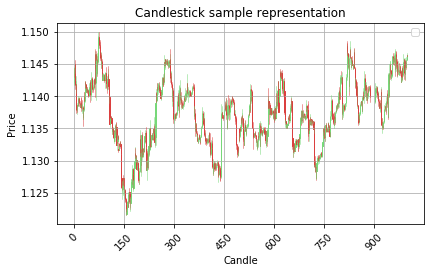

In [6]:
graph_data_ohlc(my_dataset.tail(1000).values)

### Change the format of our dataset to 3 dimensional array (Timestep, Items, Features) 

#### Custom generator function to create 3d arrays of candles sequence

In [7]:
def my_generator(data,lookback):
    
    final_output = []
    counter = 0
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    
    for a in range(len(data)-lookback):
        
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            temp_list.append(candle)
    
        
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
    
        first_row=first_row+1
        
    
    return arr

In [8]:
three_dim_sequence = np.asarray(my_generator(my_dataset.values[1:],6))

Let's check the shape of our 3 dimension array, we got:
37557 sequences of 3 candles,
each candle has 4 parameters.

In [9]:
three_dim_sequence.shape

(37554, 6, 4)

### OK, now it is time to see how our sequence of 3 candlesticks looks like on the actual chart

Visualize the step by step sequency of price movements on the OHLC chart

No handles with labels found to put in legend.


Step 1


No handles with labels found to put in legend.


Step 2


Step 3


No handles with labels found to put in legend.


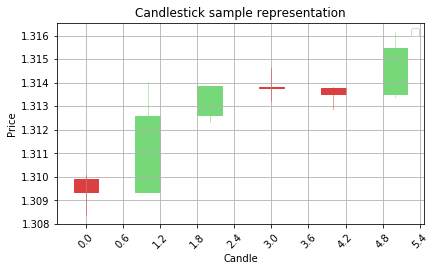

No handles with labels found to put in legend.


Step 4


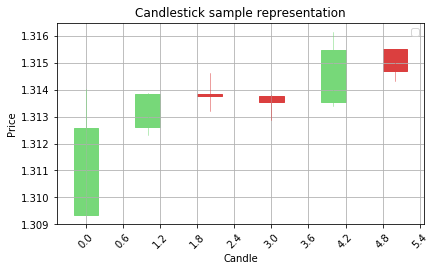

No handles with labels found to put in legend.


Step 5


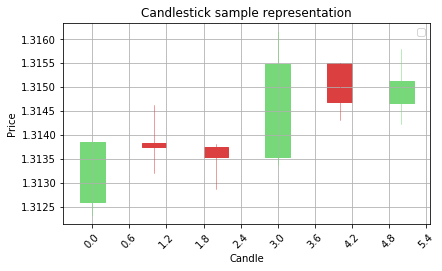

No handles with labels found to put in legend.


Step 6


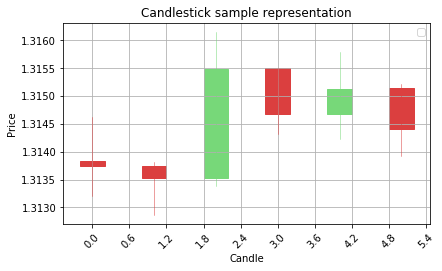

Step 7


No handles with labels found to put in legend.


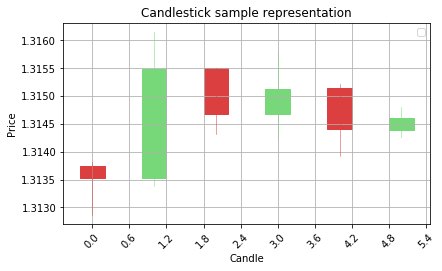

No handles with labels found to put in legend.


Step 8


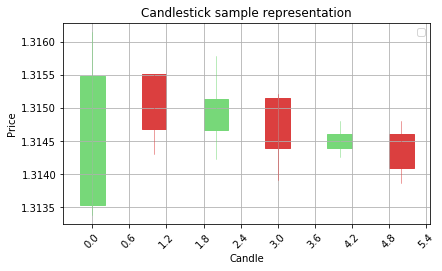

No handles with labels found to put in legend.


Step 9


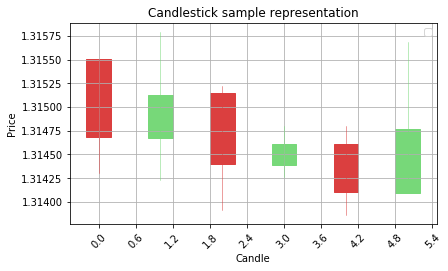

No handles with labels found to put in legend.


Step 10


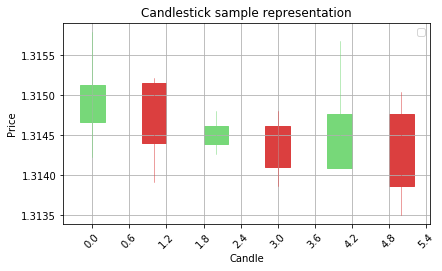

In [10]:
counter=0
for candle in three_dim_sequence[1000:1010]:
    counter=counter+1
    print('Step ' + str(counter))
    graph_data_ohlc(candle)

##  Now it is time to convert the price data in to actual candlestick parameters. Each candle has 4 parameters:

1. Size of the body measured by pips  
2. Size of the upper wicks measured by pips
3. Size of the lower wicks measured by pips
4. Type of the candle (Bullish or Bearish)(Green or Red)(0 or 1)

pip = diffrence between 2 prices multiplied by 10000

(The whole process of enriching the raw dataset is called 'feature engineering')

### Function to convert OHLC data in to candlestick parameters data

In [11]:
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]
    
    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]
        if body_size < 0:body_size=body_size*(-1)
    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]
        if body_size < 0:body_size=body_size*(-1)
    
    
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000,2)
    candlestick_data[2]=round(round(wicks_down,5)*10000,2)
    candlestick_data[3]=round(round(body_size,5)*10000,2)
    
    return candlestick_data

Lets extract data of only one candle from our dataset of sequences

In [12]:
one_candle_data_ohlc=three_dim_sequence[1000:1010][5][1]

In [13]:
one_candle_data_ohlc

array([1.31375, 1.31381, 1.31286, 1.31353])

Convert it to candlestick parameters

In [14]:
one_candle_data_ohlc_candle=ohlc_to_candlestick(one_candle_data_ohlc)

In [15]:
one_candle_data_ohlc_candle

[0, 0.6, -6.7, 2.8]

### Apply this function in to generator function to get sequences with candlestick data instead of OHLC data

In [16]:
def my_generator_candle(data,lookback):
    
    first_row = 0
    arr = np.empty((1,lookback,4), int)
    
    for a in range(len(data)-lookback):
        
        temp_list = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
    
        
        temp_list2 = np.asarray(temp_list)
        templist3 = [temp_list2]
        templist4 = np.asarray(templist3)
        arr = np.append(arr, templist4, axis=0)
    
        first_row=first_row+1
        
    
    return arr

In [17]:
three_dim_sequence_candle=my_generator_candle(my_dataset.values[1:],6)

Check if conversion applied correctly

In [18]:
three_dim_sequence_candle[5000:5005]

array([[[ 0. ,  3.2, -8.6, 10. ],
        [ 1. ,  2.2, -8.2, 11. ],
        [ 0. ,  2.5, -9.1,  2.7],
        [ 1. ,  6.2, -3.2,  5.3],
        [ 0. ,  0.6, -5.4, 16.2],
        [ 0. ,  3.4, -6. ,  7.4]],

       [[ 1. ,  2.2, -8.2, 11. ],
        [ 0. ,  2.5, -9.1,  2.7],
        [ 1. ,  6.2, -3.2,  5.3],
        [ 0. ,  0.6, -5.4, 16.2],
        [ 0. ,  3.4, -6. ,  7.4],
        [ 1. ,  4.8, -8.8,  0.1]],

       [[ 0. ,  2.5, -9.1,  2.7],
        [ 1. ,  6.2, -3.2,  5.3],
        [ 0. ,  0.6, -5.4, 16.2],
        [ 0. ,  3.4, -6. ,  7.4],
        [ 1. ,  4.8, -8.8,  0.1],
        [ 1. ,  1.9, -0.2, 17. ]],

       [[ 1. ,  6.2, -3.2,  5.3],
        [ 0. ,  0.6, -5.4, 16.2],
        [ 0. ,  3.4, -6. ,  7.4],
        [ 1. ,  4.8, -8.8,  0.1],
        [ 1. ,  1.9, -0.2, 17. ],
        [ 0. ,  4.1, -3. ,  6.5]],

       [[ 0. ,  0.6, -5.4, 16.2],
        [ 0. ,  3.4, -6. ,  7.4],
        [ 1. ,  4.8, -8.8,  0.1],
        [ 1. ,  1.9, -0.2, 17. ],
        [ 0. ,  4.1, -3. ,  6.5],
      

## Generate forecasting data

Now we have our candlestick values in the correct format for machine to read it and interpret it so, it is time
to generete our prediction/forecasting data.

The idea was to predict the next candle type (bullish or bearish) by looking on for the last 3 candles.
We got our sequences of 3 candles and now we need to generate another array with one candle information,
which we will be forecasting.

#### Update of the generator to return one more array with 1 or 0 (Bullish or Bearish)

In [19]:
def my_generator_candle_X_Y(data,lookback):
    
    first_row = 0
    
    arr = np.empty((0,lookback,4))
    arr3 = np.empty((0,lookback,4))
    Y_list = []
    for a in range(len(data)-lookback):
        
        temp_list = []
        temp_list_raw = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
            temp_list_raw.append(candle)
        
        
        temp_list3 = [np.asarray(temp_list)]
        templist4 = np.asarray(temp_list3)
        arr = np.append(arr, templist4, axis=0)
        
        temp_list7 = [np.asarray(temp_list_raw)]
        templist8 = np.asarray(temp_list7)
        arr3 = np.append(arr3, templist8, axis=0)

        converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])
        Prediction = converted_data_prediction[0]
        Y_list.append(Prediction)
        

        
        first_row=first_row+1
        
    
    arr2 = np.asarray(Y_list)
    
    return arr,arr2,arr3

#### We will call the function and receive 2 datasets:

X = Input dataset on which our neural network will make predictions

Y = Prediction dataset (results of the correct predictions)

In [20]:
X,Y, X_raw = my_generator_candle_X_Y(my_dataset.values,3)

Exploring the genereted dataset:

In [21]:
print('Shape of X ' + str(X.shape))
print('Shape of Y ' + str(Y.shape))
print('Shape of X raw ohlc ' + str(X_raw.shape))

Shape of X (37557, 3, 4)
Shape of Y (37557,)
Shape of X raw ohlc (37557, 3, 4)


In [22]:
X[653]

array([[ 1. ,  4.5, -0.3, 15.8],
       [ 1. ,  2.6, -1. ,  9. ],
       [ 0. ,  6.3, -7.2, 13.8]])

In [23]:
Y[652]

0

In [24]:
X_raw[652]

array([[1.35061, 1.35112, 1.35061, 1.35107],
       [1.35109, 1.35312, 1.35106, 1.35267],
       [1.35267, 1.35383, 1.35257, 1.35357]])

#### Visualize the candle sequence:

No handles with labels found to put in legend.


Prediction is Bearsih


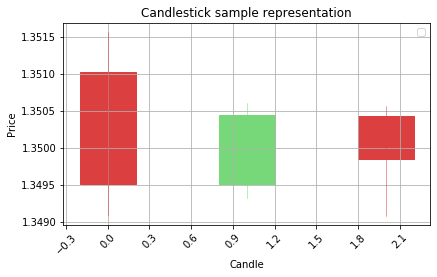

No handles with labels found to put in legend.


Prediction is Bearsih


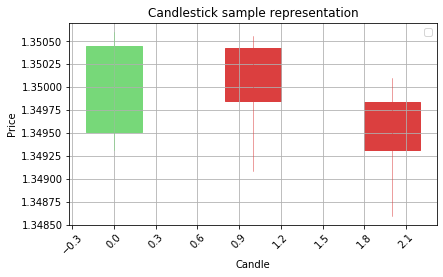

Prediction is Bearsih


No handles with labels found to put in legend.


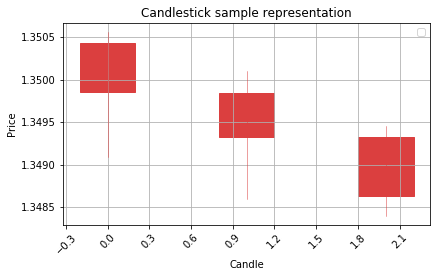

Prediction is Bearsih


No handles with labels found to put in legend.


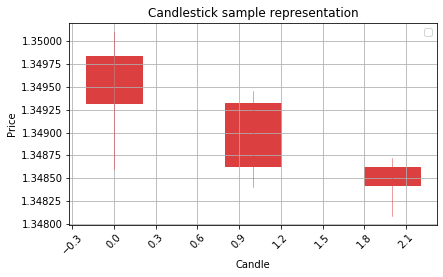

Prediction is Bullish


No handles with labels found to put in legend.


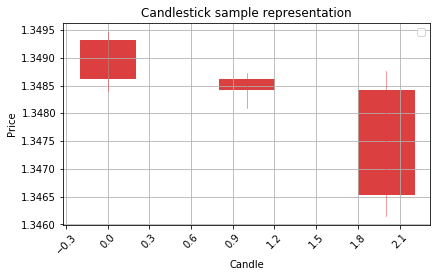

Prediction is Bullish


No handles with labels found to put in legend.


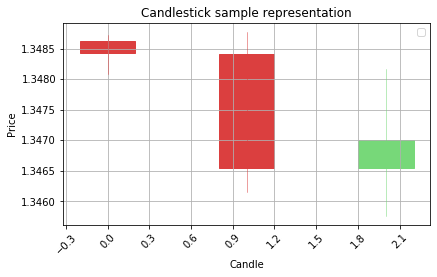

Prediction is Bearsih


No handles with labels found to put in legend.


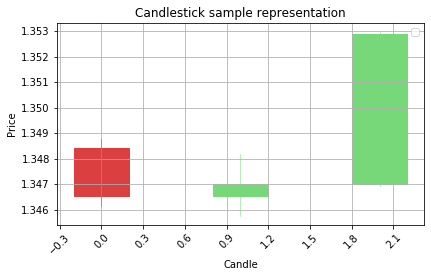

Prediction is Bullish


No handles with labels found to put in legend.


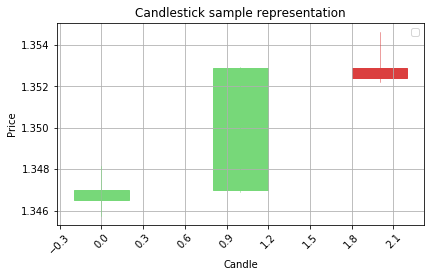

No handles with labels found to put in legend.


Prediction is Bullish


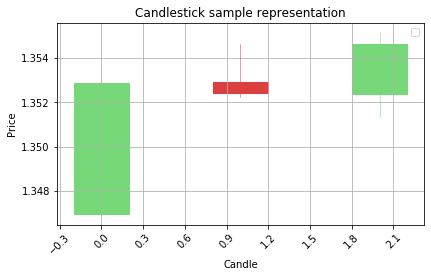

No handles with labels found to put in legend.


Prediction is Bearsih


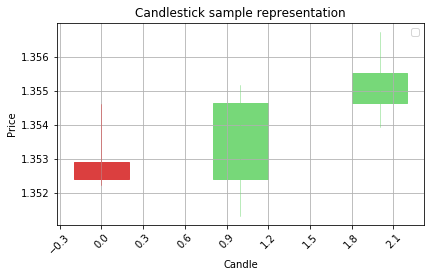

In [25]:
for a in range(10):
    b=a+600
    if Y[b] == 1:print('Prediction is Bullish')
    if Y[b] == 0:print('Prediction is Bearsih')
    graph_data_ohlc(X_raw[b])

# Build Deep Neural Network model

#### For all sequence dataset the best model are RNN - Recurrent neural network. For our case we will build the LSTM network ( Long-Term Short-Term) 

The basics, for all the training and prediction will be responsible the tensorflow library, with high level API called KERAS.

## Defining the model

In [26]:
from keras import layers
from keras.optimizers import RMSprop
max_features=100

model = Sequential()

#model.add(layers.Embedding(max_features, 128))

model.add(layers.CuDNNLSTM(units = 128, return_sequences = True, input_shape = (None, X.shape[-1])))
model.add(layers.Dropout(0.2))

model.add(layers.CuDNNLSTM(units = 256, return_sequences = True))
model.add(layers.Dropout(0.2))

model.add(layers.CuDNNLSTM(units = 500))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = 1))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


#### Definition of the compiled model

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, None, 128)         68608     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, None, 256)         395264    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 500)               1516000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

### In order train the deep learning model we need to split our data for 3 parts:
1. Traning dataset
2. Validation dataset
3. Test dataset

In [28]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

X_train_raw, X_val_and_test_raw= train_test_split(X_raw, test_size=0.3)
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.5)


In [29]:
print('Training data: ' + 'X Input shape: ' + str(X_train.shape) + ', ' + 'Y Output shape: ' + str(Y_train.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))
print('Validation data: ' + 'X Input shape: ' + str(X_val.shape) + ', ' + 'Y Output shape: ' + str(Y_val.shape) + ', ' + 'datetime shape: ' + str(Y_val.shape))
print('Test data: ' + 'X Input shape: ' + str(X_test.shape) + ', ' + 'Y Output shape: ' + str(Y_test.shape) + ', ' + 'datetime shape: ' + str(Y_test.shape))

Training data: X Input shape: (26289, 3, 4), Y Output shape: (26289,), datetime shape: (26289,)
Validation data: X Input shape: (5634, 3, 4), Y Output shape: (5634,), datetime shape: (5634,)
Test data: X Input shape: (5634, 3, 4), Y Output shape: (5634,), datetime shape: (5634,)


### Train the Neural Network model and save trainig outputs 'history' variable

In [31]:
history = model.fit(X_train, Y_train,batch_size=500, epochs=100,validation_data=(X_val, Y_val))

Train on 26289 samples, validate on 5634 samples
Epoch 1/10
26289/26289 [==============================] - 14s 545us/step - loss: 0.8357 - acc: 0.4972 - val_loss: 0.7102 - val_acc: 0.5016
Epoch 2/10
26289/26289 [==============================] - 3s 125us/step - loss: 0.7060 - acc: 0.5083 - val_loss: 0.6937 - val_acc: 0.5099
Epoch 3/10
26289/26289 [==============================] - 3s 124us/step - loss: 0.7039 - acc: 0.5050 - val_loss: 0.6926 - val_acc: 0.5126
Epoch 4/10
26289/26289 [==============================] - 3s 125us/step - loss: 0.6998 - acc: 0.5014 - val_loss: 0.7040 - val_acc: 0.5016
Epoch 5/10
26289/26289 [==============================] - 3s 125us/step - loss: 0.6965 - acc: 0.5101 - val_loss: 0.7075 - val_acc: 0.5016
Epoch 6/10
26289/26289 [==============================] - 3s 123us/step - loss: 0.6964 - acc: 0.5025 - val_loss: 0.6947 - val_acc: 0.5034
Epoch 7/10
26289/26289 [==============================] - 3s 121us/step - loss: 0.6958 - acc: 0.5052 - val_loss: 0.6914 - 

### Plot the charts to see model training loss and validation loss

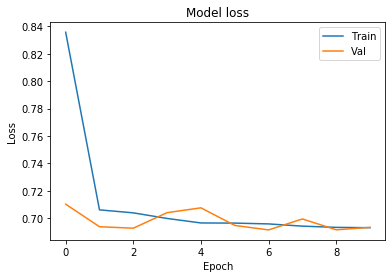

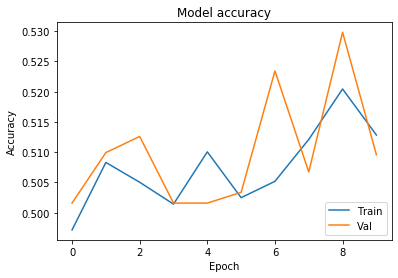

In [32]:
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()


### Test the model against new data

In [33]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

5634/5634 [==============================] - 1s 174us/step
Test accuracy: 0.5003549875754348


### Visualize the predictions on the candlestick charts to see the patterns

No handles with labels found to put in legend.


[0.5506513]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


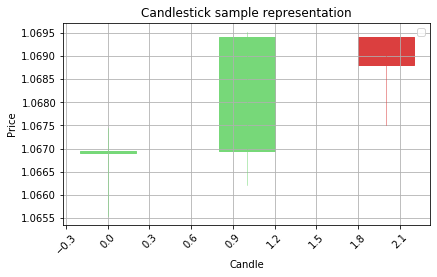

No handles with labels found to put in legend.


[0.5619145]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


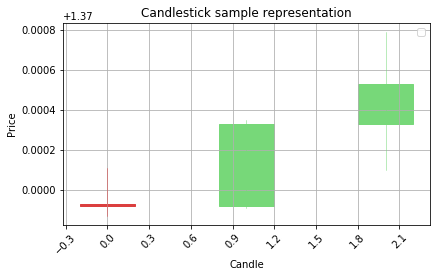

No handles with labels found to put in legend.


[0.5608105]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


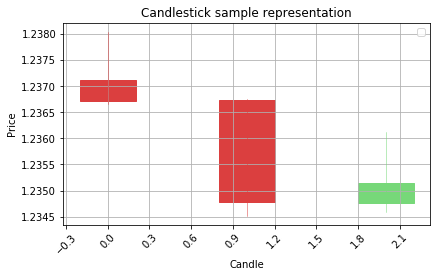

No handles with labels found to put in legend.


[0.56580865]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


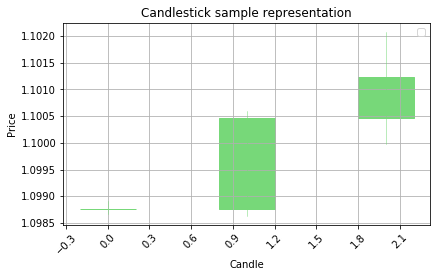

No handles with labels found to put in legend.


[0.5565435]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


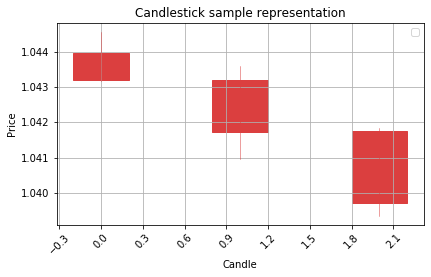

No handles with labels found to put in legend.


[0.5717809]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


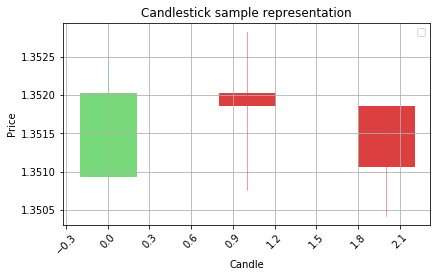

[0.5525454]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


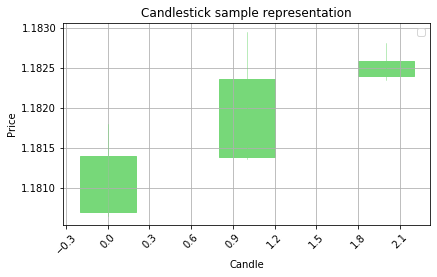

No handles with labels found to put in legend.


[0.5631943]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


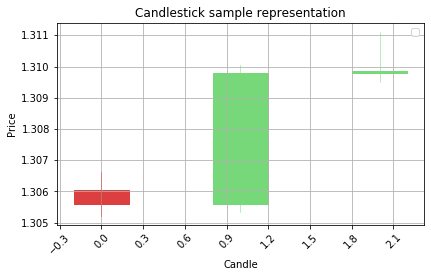

[0.5715395]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


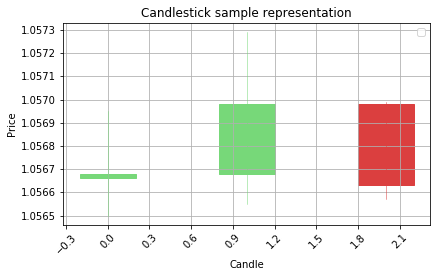

No handles with labels found to put in legend.


[0.5565325]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


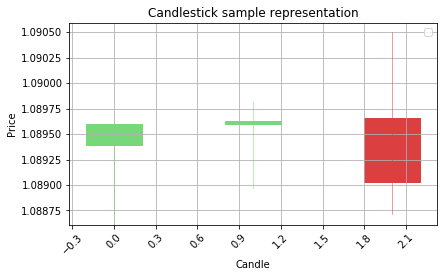

No handles with labels found to put in legend.


[0.56266296]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


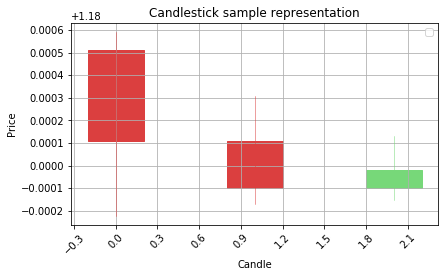

No handles with labels found to put in legend.


[0.55574495]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


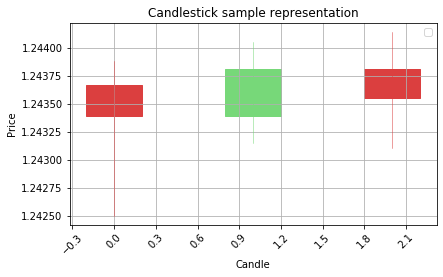

[0.56138813]

No handles with labels found to put in legend.



Correct prediction is Bearsih
Model prediction is Bearsih
WON


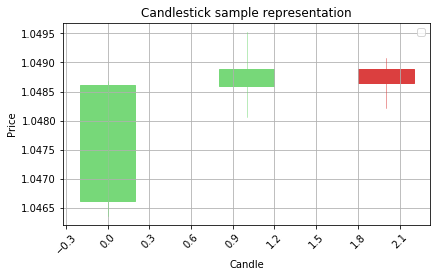

[0.5581872]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


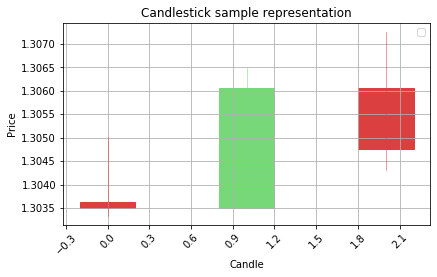

No handles with labels found to put in legend.


[0.5715546]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


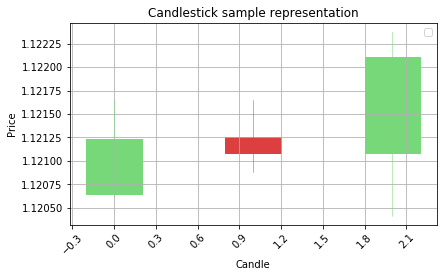

[0.55769503]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


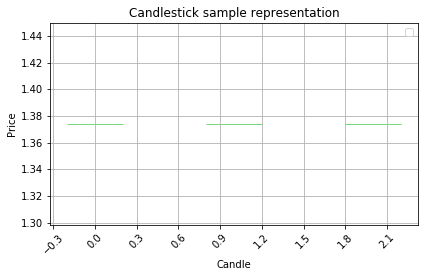

[0.551058]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


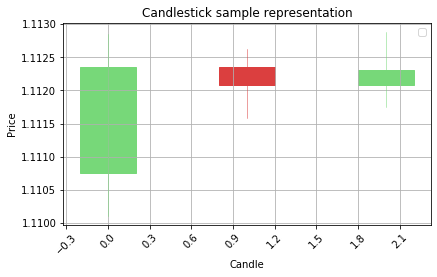

No handles with labels found to put in legend.


[0.57768786]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


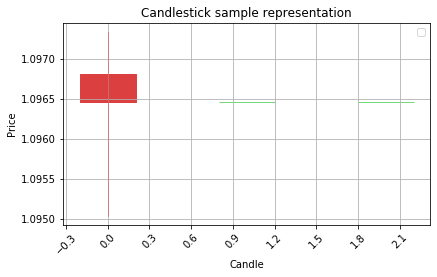

No handles with labels found to put in legend.


[0.5590239]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.5630351]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.55551374]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


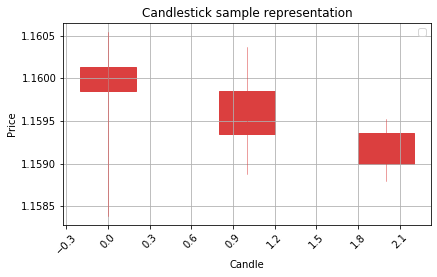

No handles with labels found to put in legend.


[0.565587]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


[0.56398994]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


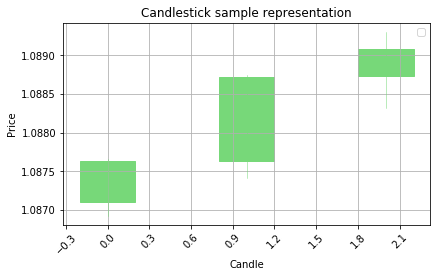

[0.5560489]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


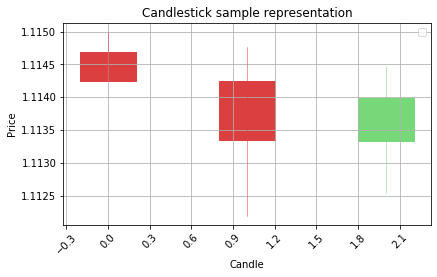

No handles with labels found to put in legend.


[0.56469935]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


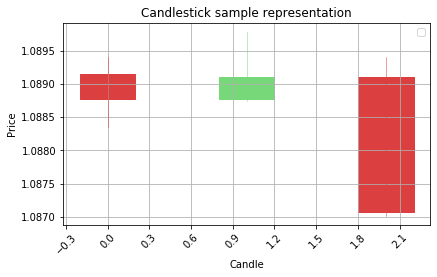

[0.5672684]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


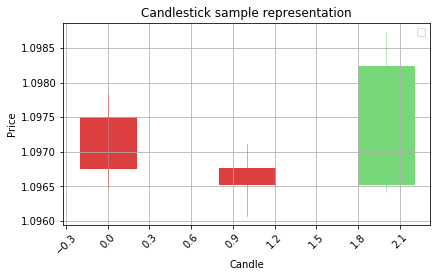

[0.55697954]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


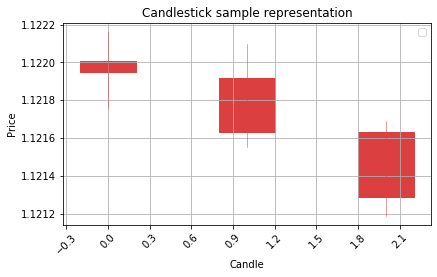

[0.55279016]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


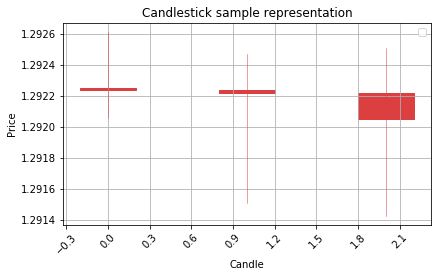

No handles with labels found to put in legend.


[0.55204356]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


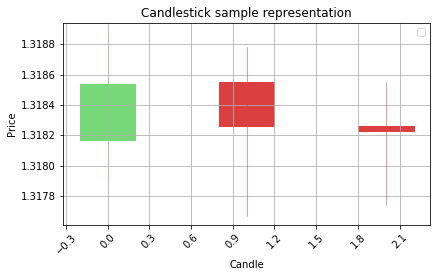

[0.5531856]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


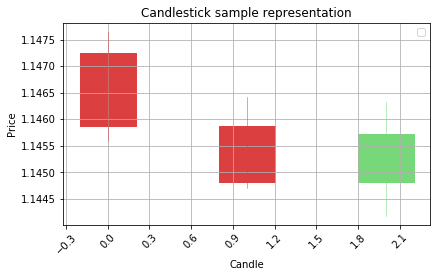

No handles with labels found to put in legend.


[0.5524974]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


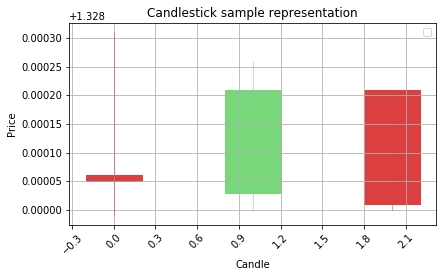

[0.5605407]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


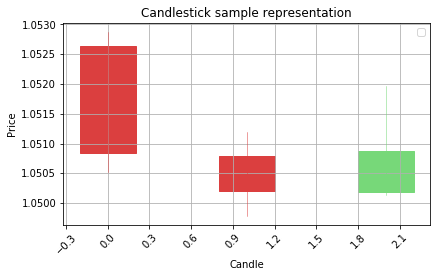

No handles with labels found to put in legend.


[0.553504]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


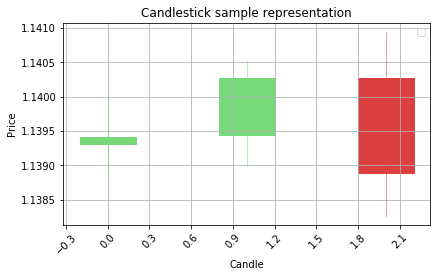

[0.5589942]

No handles with labels found to put in legend.



Correct prediction is Bullish
Model prediction is Bearsih
LOST


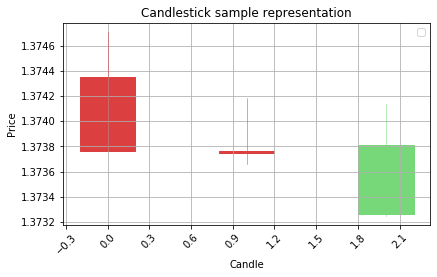

No handles with labels found to put in legend.


[0.55847937]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


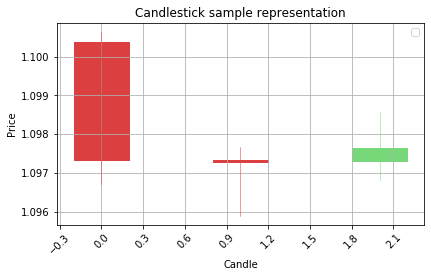

No handles with labels found to put in legend.


[0.5539613]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


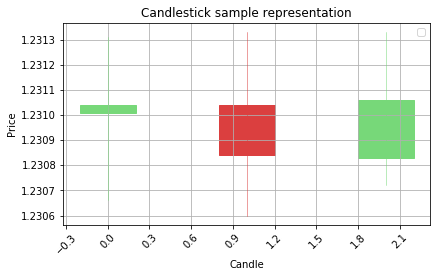

No handles with labels found to put in legend.


[0.5541339]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


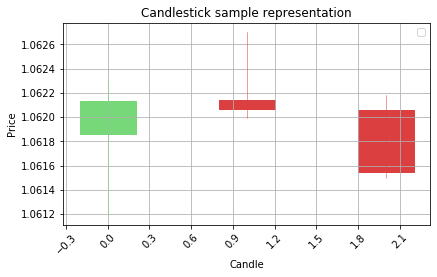

No handles with labels found to put in legend.


[0.564109]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


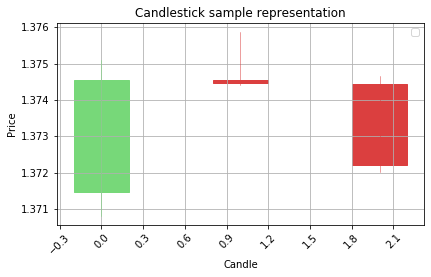

No handles with labels found to put in legend.


[0.5551561]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


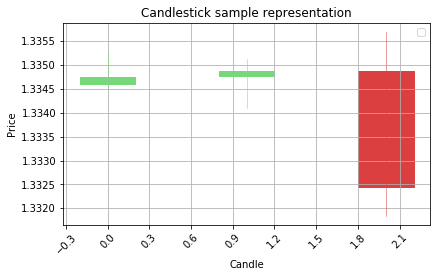

No handles with labels found to put in legend.


[0.5516944]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


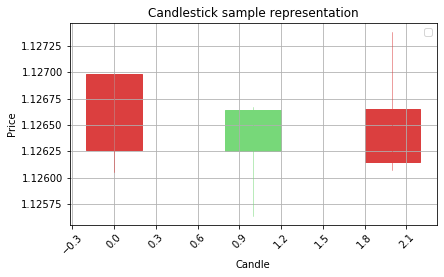

No handles with labels found to put in legend.


[0.55249417]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


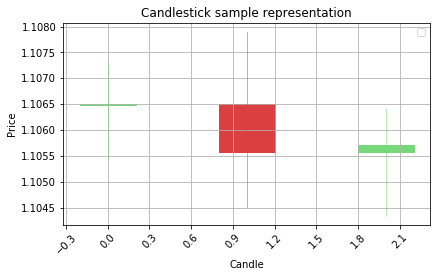

No handles with labels found to put in legend.


[0.5524403]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


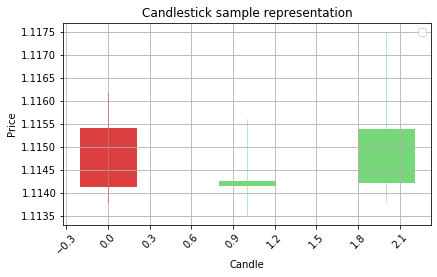

No handles with labels found to put in legend.


[0.5622057]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


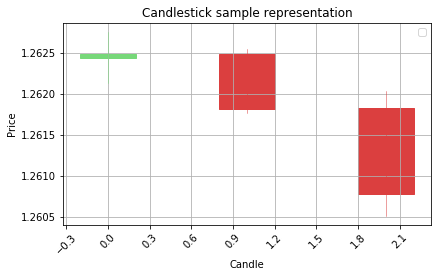

[0.55154276]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


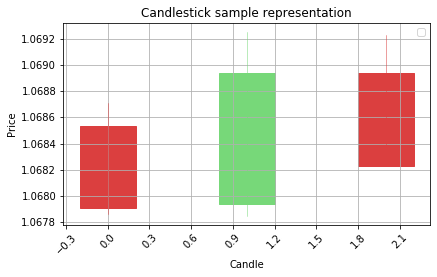

No handles with labels found to put in legend.


[0.5529631]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


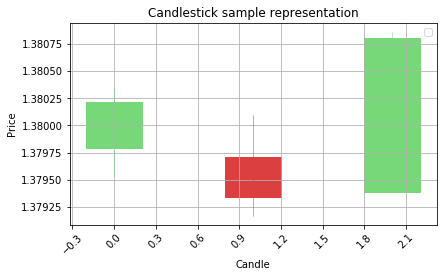

No handles with labels found to put in legend.


[0.5684697]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


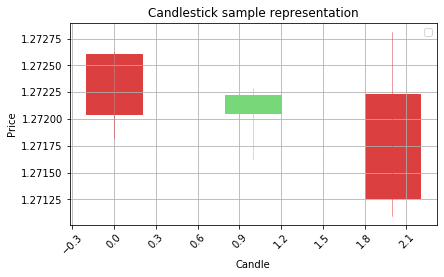

[0.563305]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


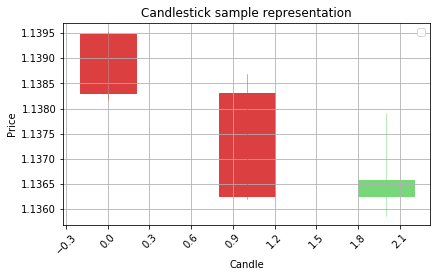

No handles with labels found to put in legend.


[0.56822366]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


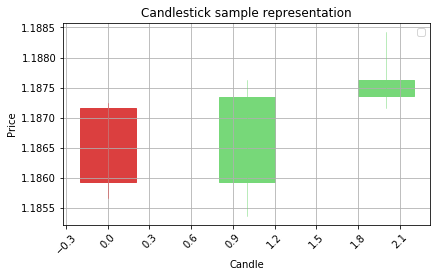

No handles with labels found to put in legend.


[0.5598124]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


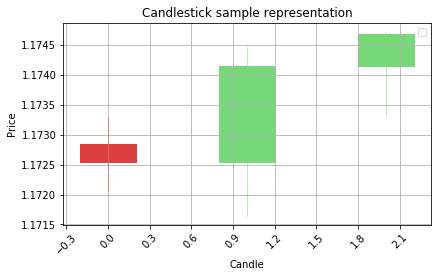

No handles with labels found to put in legend.


[0.55427086]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


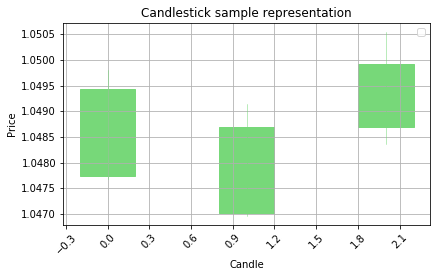

No handles with labels found to put in legend.


[0.57396555]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


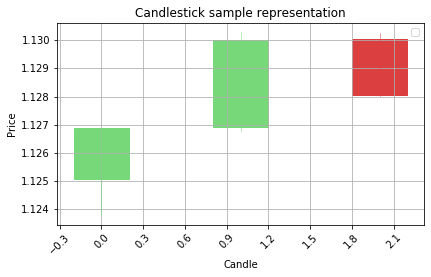

No handles with labels found to put in legend.


[0.56128365]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


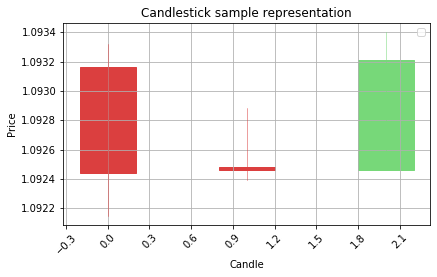

[0.56975675]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


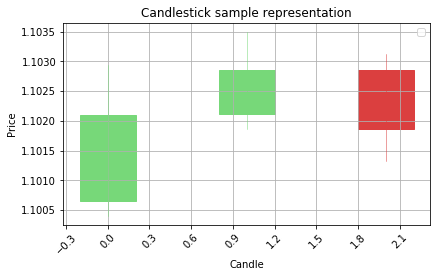

No handles with labels found to put in legend.


[0.56483644]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


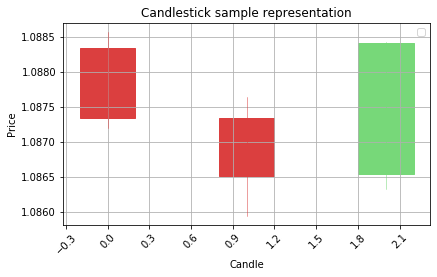

[0.56679636]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


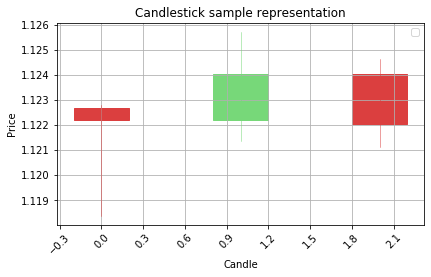

No handles with labels found to put in legend.


[0.56713235]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


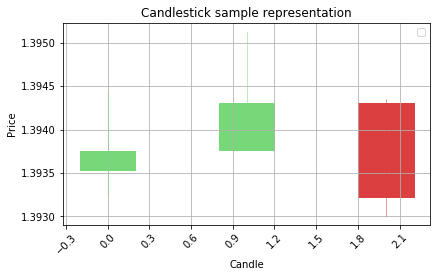

[0.565333]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


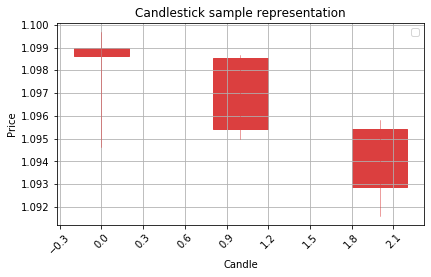

No handles with labels found to put in legend.


[0.56195116]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


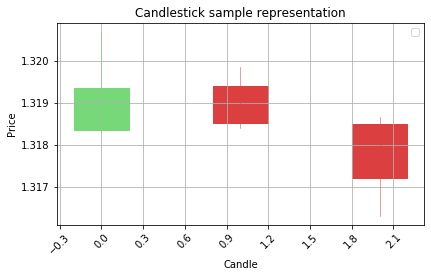

[0.55039835]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


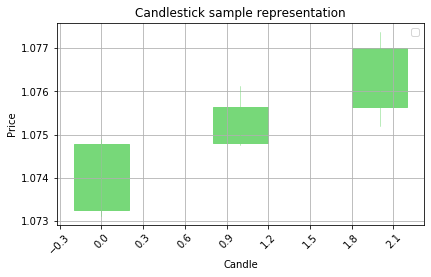

[0.55856436]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


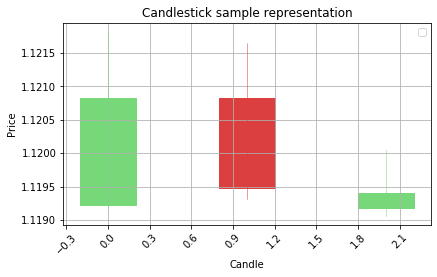

No handles with labels found to put in legend.


[0.55742145]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


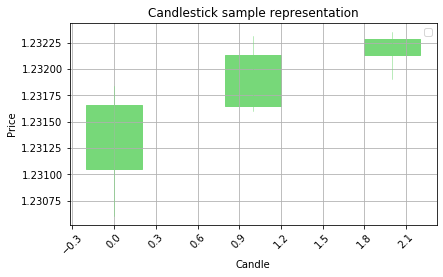

No handles with labels found to put in legend.


[0.5525683]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


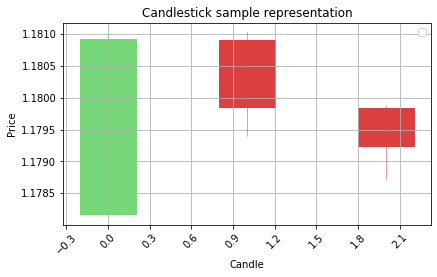

[0.5670496]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


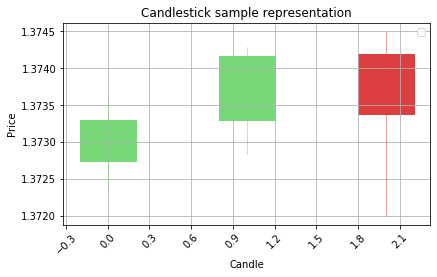

[0.55789727]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


[0.56304425]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


No handles with labels found to put in legend.


[0.56466794]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


[0.56438065]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


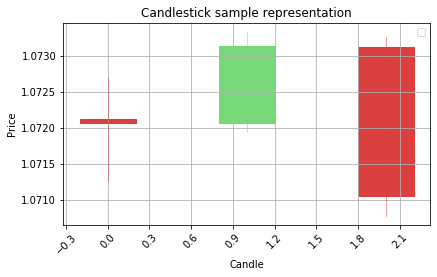

[0.5581659]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


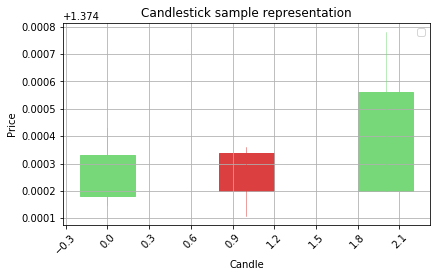

No handles with labels found to put in legend.


[0.5646784]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


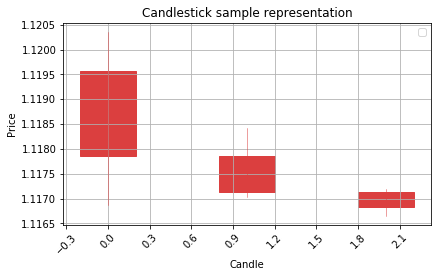

[0.5575153]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


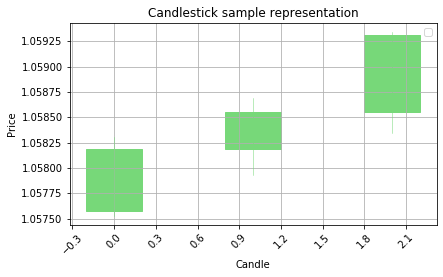

[0.5638581]
Correct prediction is Bullish


No handles with labels found to put in legend.


Model prediction is Bearsih
LOST


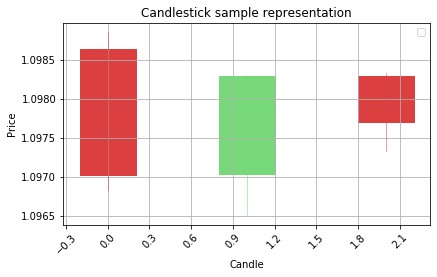

[0.55173403]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


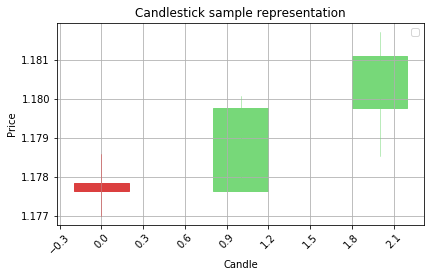

[0.5528161]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


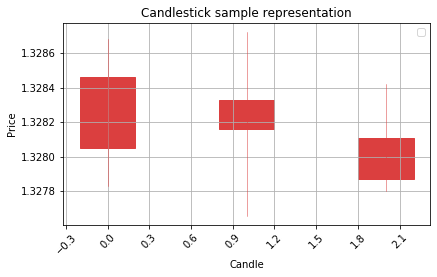

[0.5549309]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


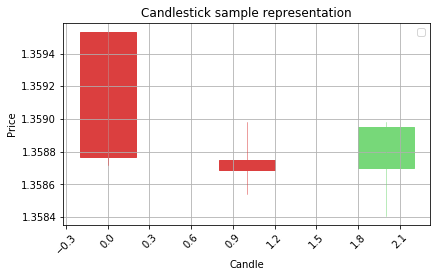

[0.56413656]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


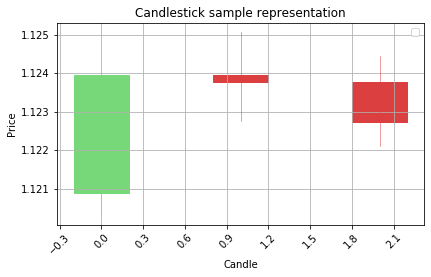

[0.5505478]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


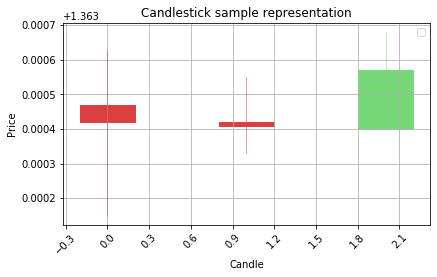

[0.5658493]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


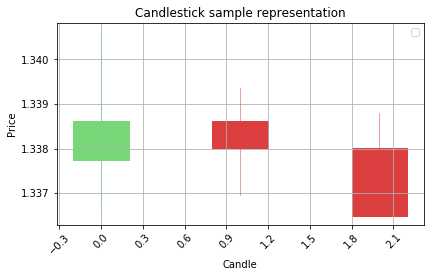

[0.5540776]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


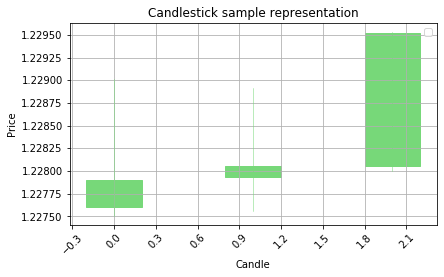

[0.55166024]
Correct prediction is Bearsih


No handles with labels found to put in legend.


Model prediction is Bearsih
WON


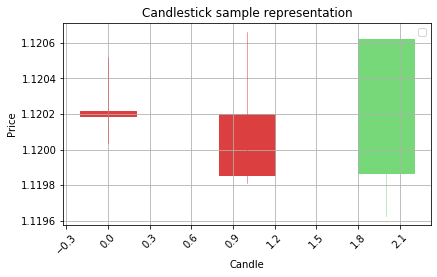

[0.5541707]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


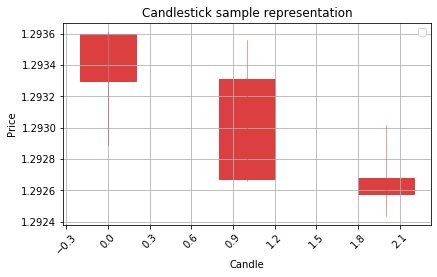

[0.55896914]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


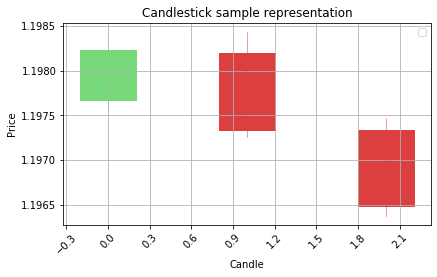

[0.5588833]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


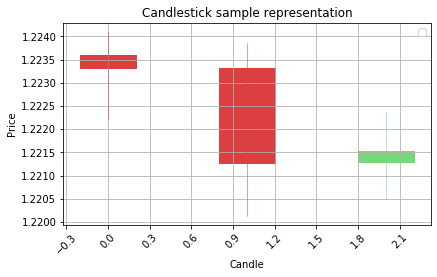

[0.55507594]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


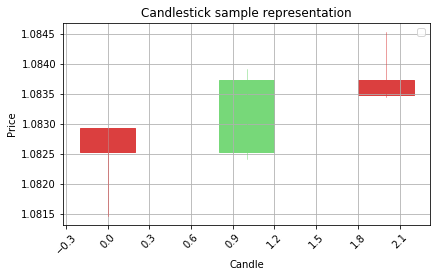

[0.5583658]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


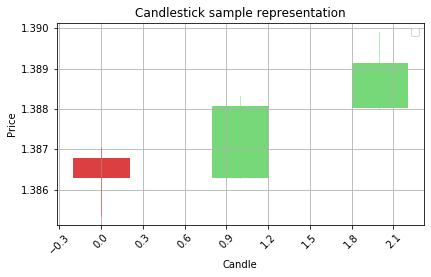

[0.5577714]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


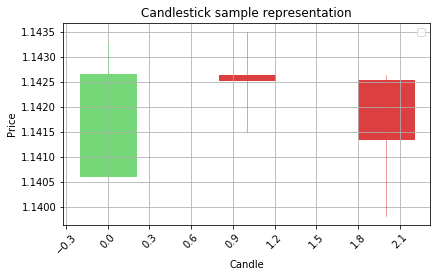

No handles with labels found to put in legend.


[0.56879896]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


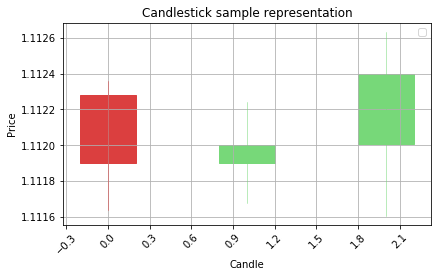

[0.55876625]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


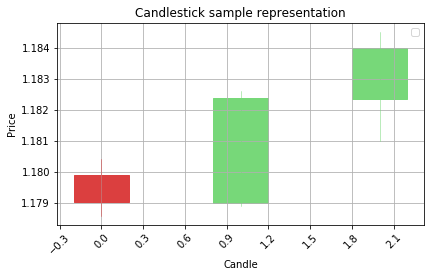

[0.5565787]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


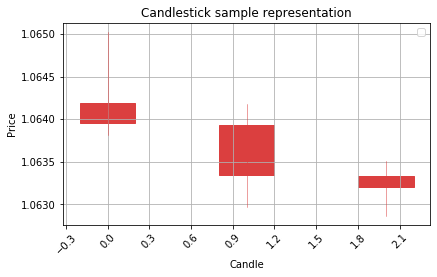

[0.5505003]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


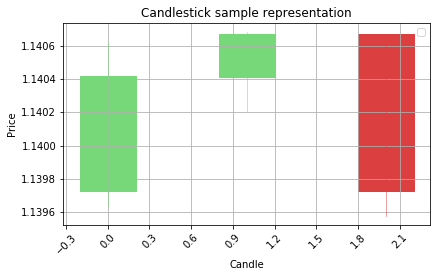

[0.5525756]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


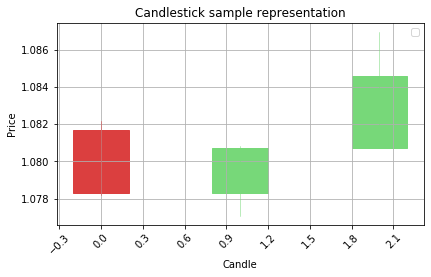

[0.5629705]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


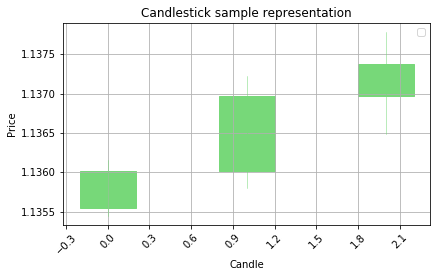

[0.554376]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


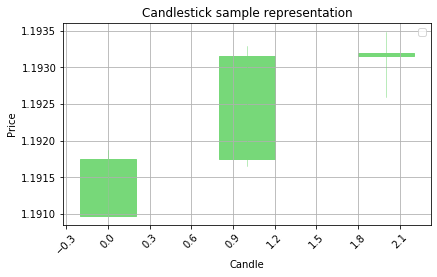

[0.56527215]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


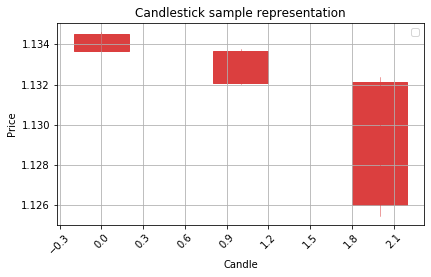

[0.5627935]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


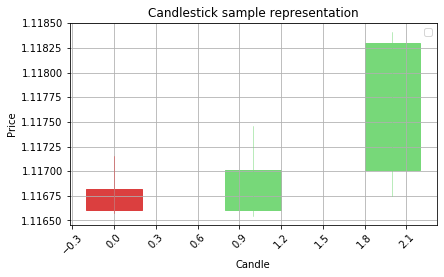

[0.55532026]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


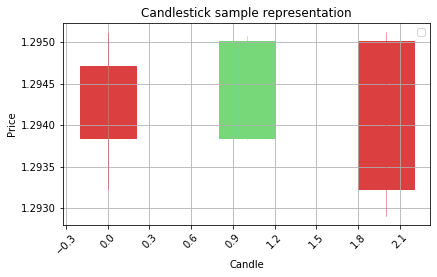

[0.5557427]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


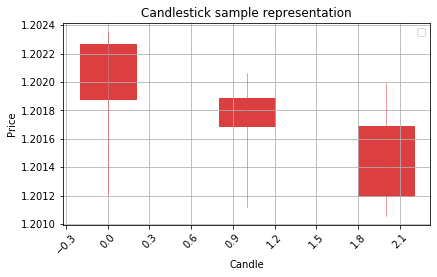

[0.56356907]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


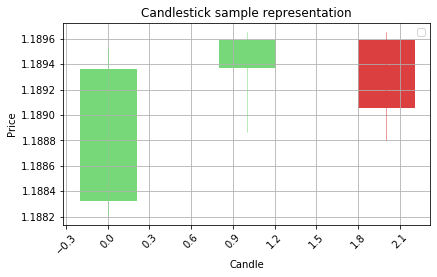

[0.5755833]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


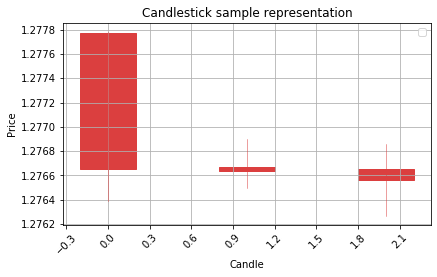

No handles with labels found to put in legend.


[0.552418]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


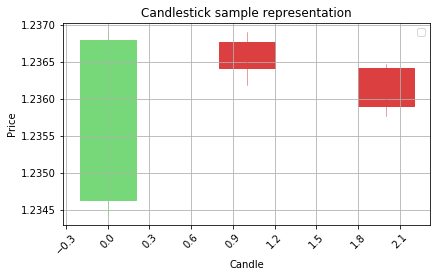

[0.5525695]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


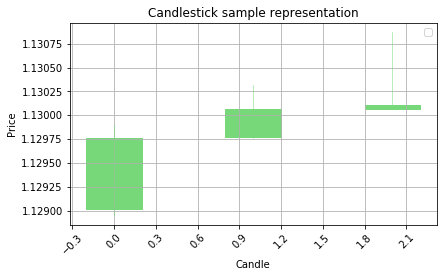

No handles with labels found to put in legend.


[0.556913]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


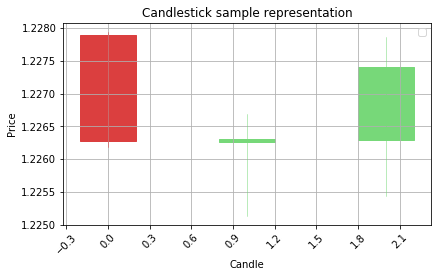

[0.57372975]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


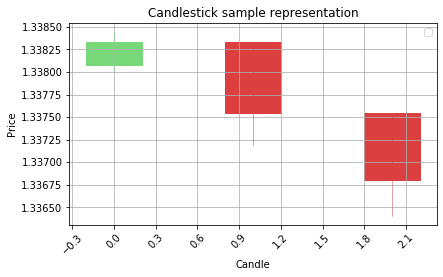

No handles with labels found to put in legend.


[0.5597117]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


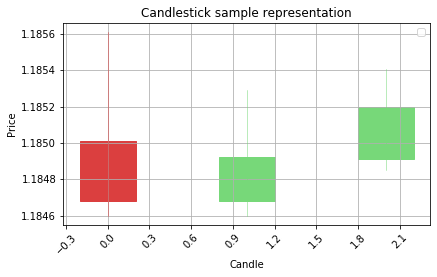

[0.56389284]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


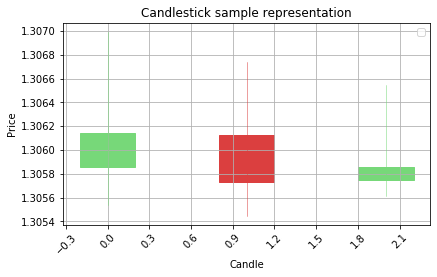

No handles with labels found to put in legend.


[0.5536591]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


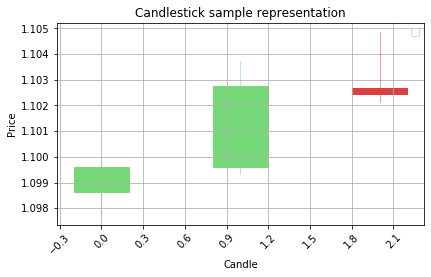

No handles with labels found to put in legend.


[0.55448776]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


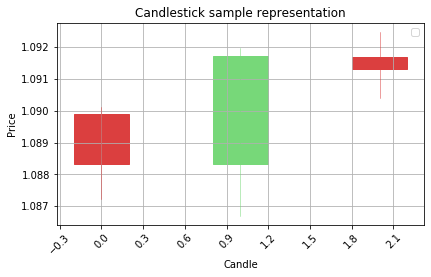

[0.5549094]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


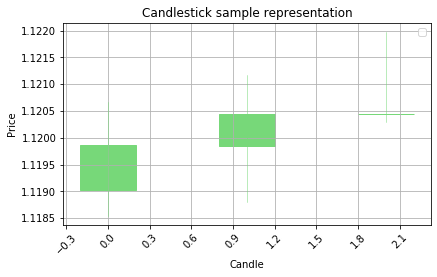

[0.56540227]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


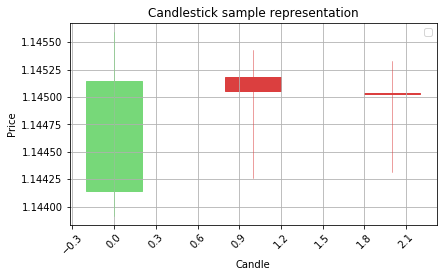

[0.5541548]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


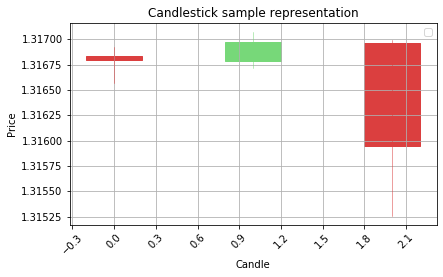

No handles with labels found to put in legend.


[0.56440085]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


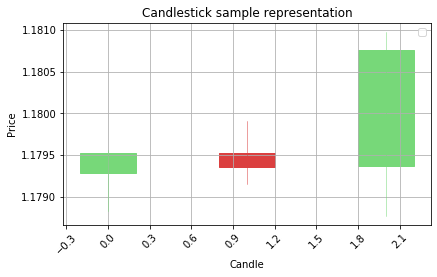

[0.5593285]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


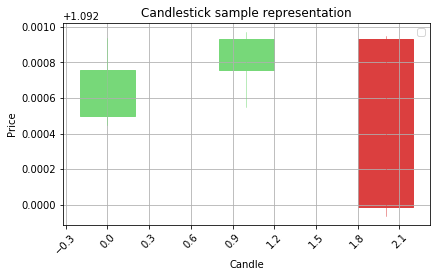

[0.5563766]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


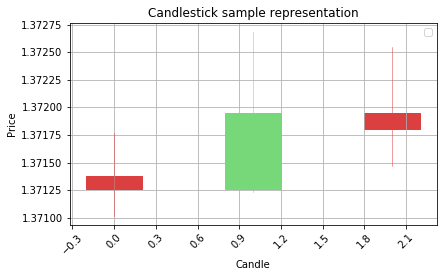

[0.5597828]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


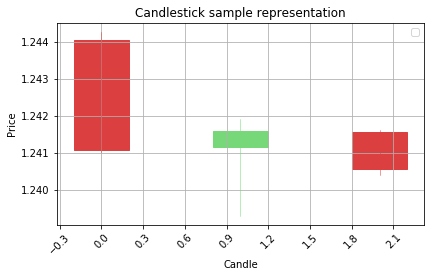

[0.55089796]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


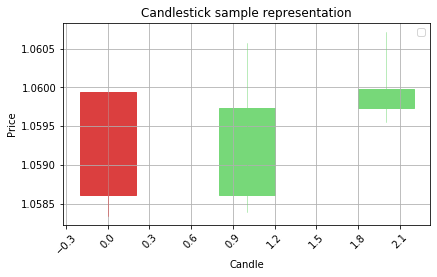

[0.5635474]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


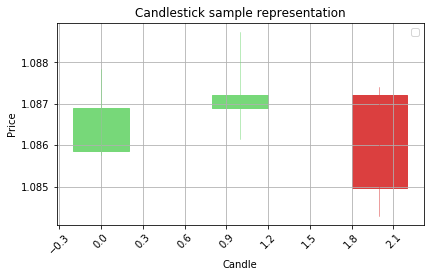

[0.5525692]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


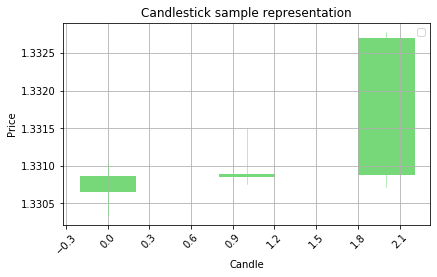

[0.5504544]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


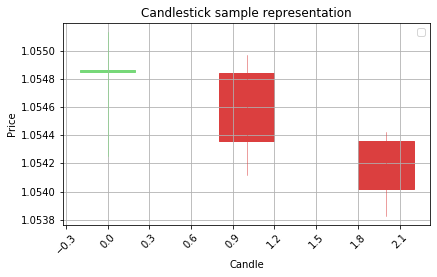

[0.5537702]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


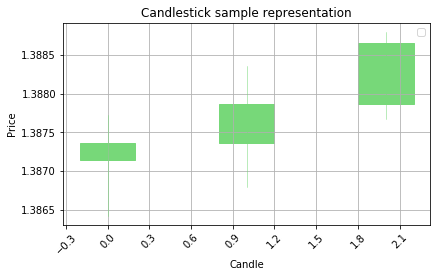

[0.5516249]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


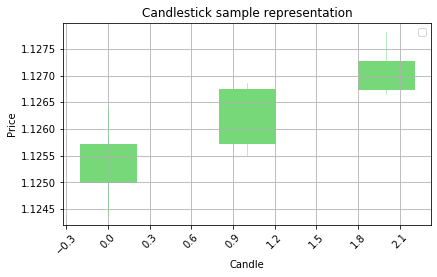

No handles with labels found to put in legend.


[0.5732597]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


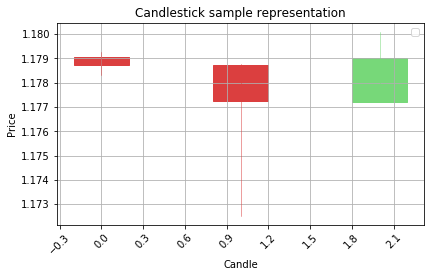

[0.57359654]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


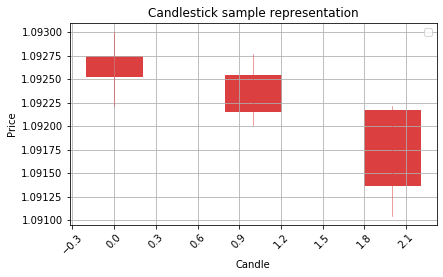

No handles with labels found to put in legend.


[0.57803893]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


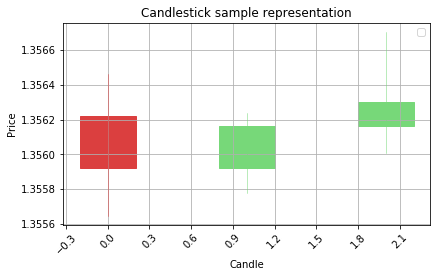

[0.55553246]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


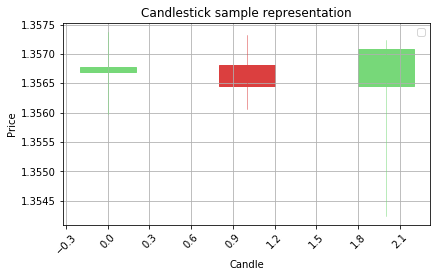

No handles with labels found to put in legend.


[0.56225765]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


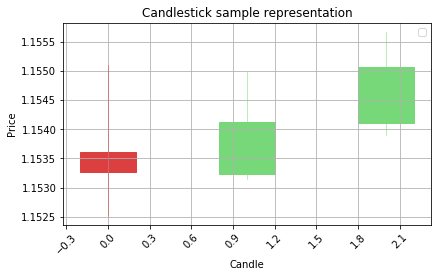

[0.55428386]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


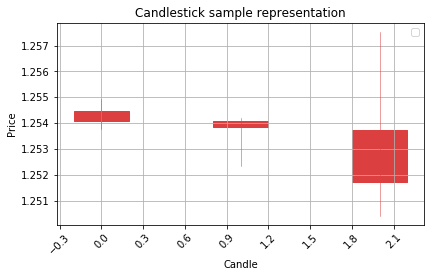

No handles with labels found to put in legend.


[0.5568806]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


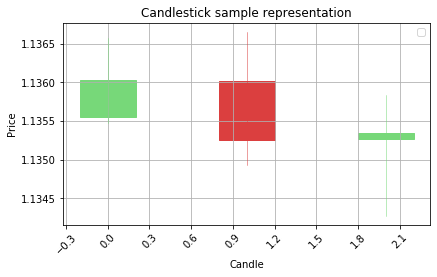

No handles with labels found to put in legend.


[0.5670563]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


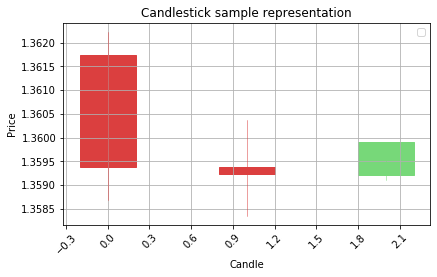

No handles with labels found to put in legend.


[0.5629257]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


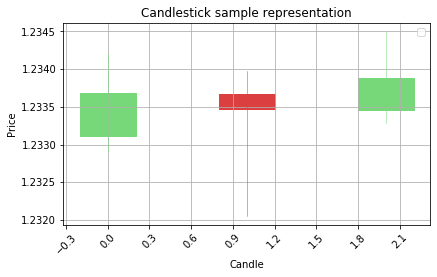

[0.56754774]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


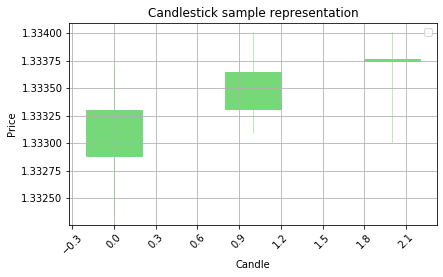

No handles with labels found to put in legend.


[0.550999]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


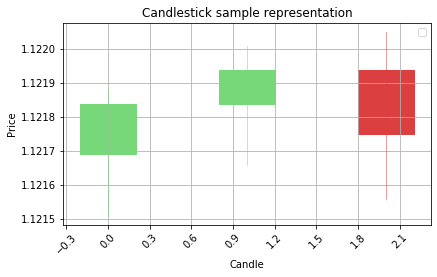

[0.5638801]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


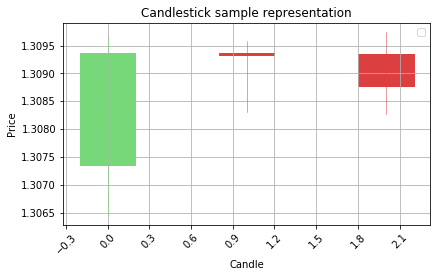

No handles with labels found to put in legend.


[0.5569933]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


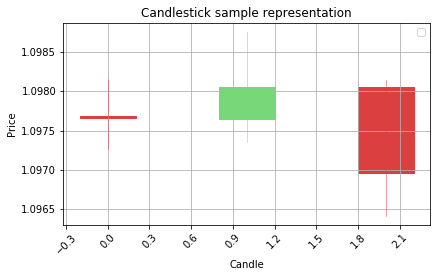

[0.5539436]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


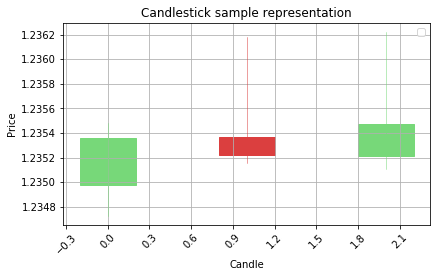

[0.56143403]
Correct prediction is Bearsih
Model prediction is Bearsih


No handles with labels found to put in legend.


WON


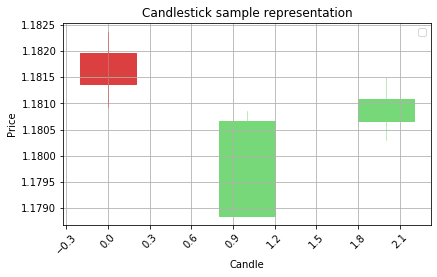

[0.5607834]

No handles with labels found to put in legend.



Correct prediction is Bearsih
Model prediction is Bearsih
WON


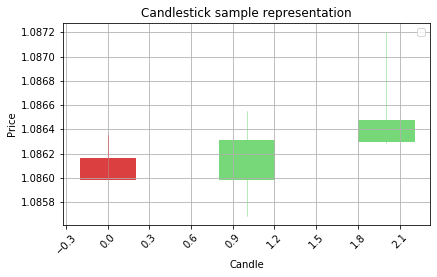

[0.56364363]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


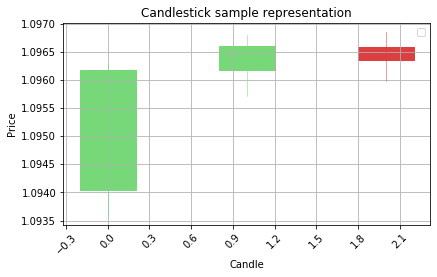

No handles with labels found to put in legend.


[0.56446517]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


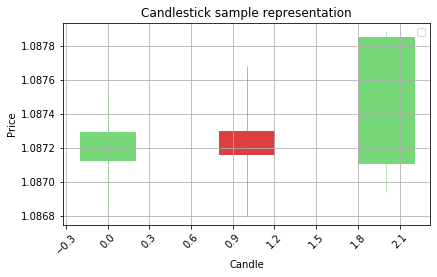

[0.55068725]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


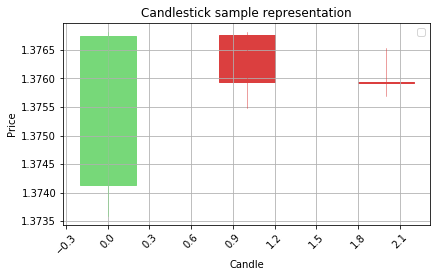

No handles with labels found to put in legend.


[0.5559465]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


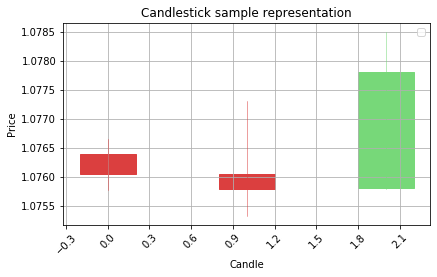

[0.5533796]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


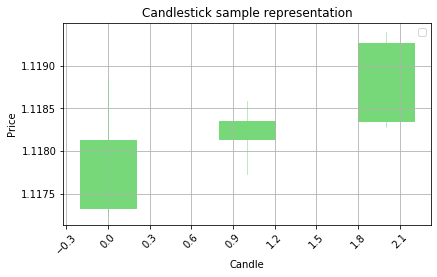

[0.55765206]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


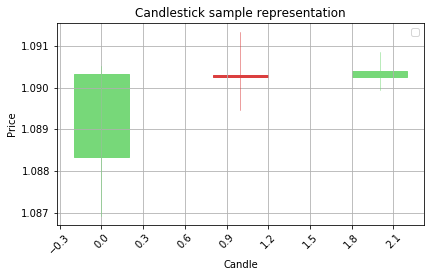

[0.5757213]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


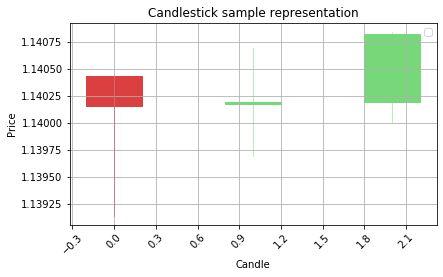

[0.55149937]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


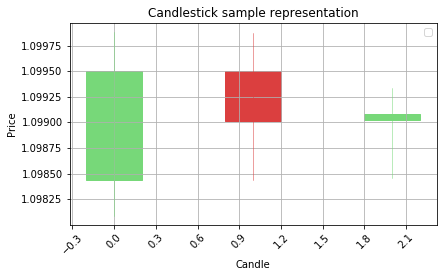

[0.56534237]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


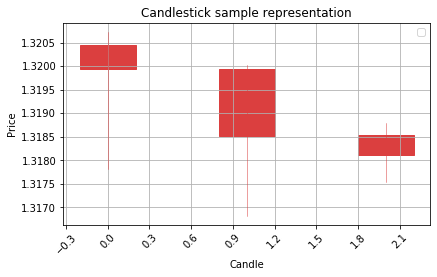

[0.55252284]

No handles with labels found to put in legend.



Correct prediction is Bullish
Model prediction is Bearsih
LOST


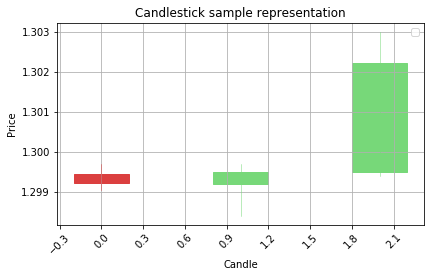

[0.5672527]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


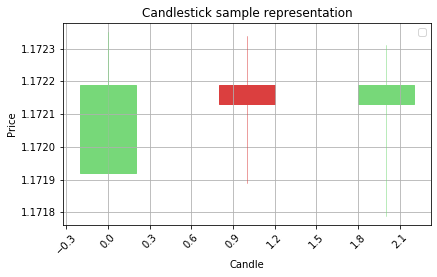

[0.55246437]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


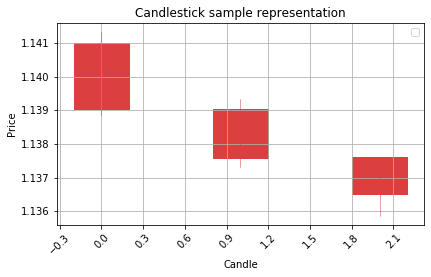

[0.552307]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


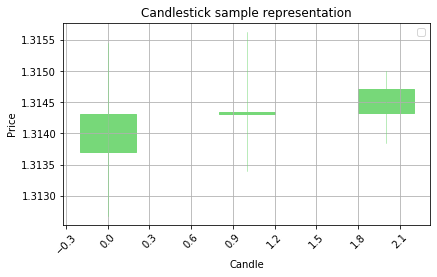

[0.5505056]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


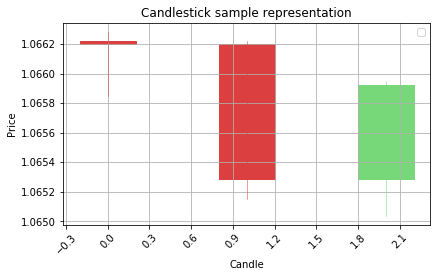

[0.56794816]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


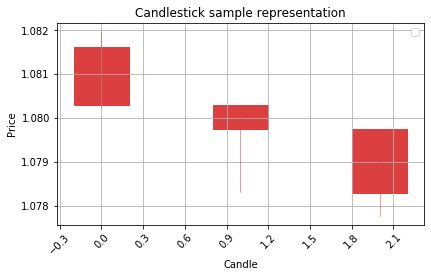

[0.55945396]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


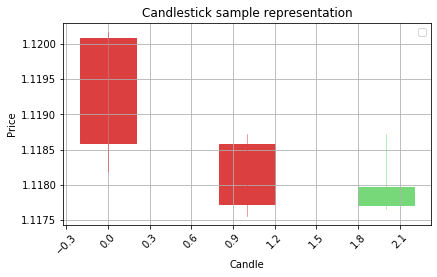

[0.56559795]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


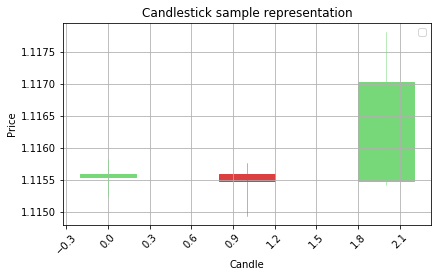

[0.55729455]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


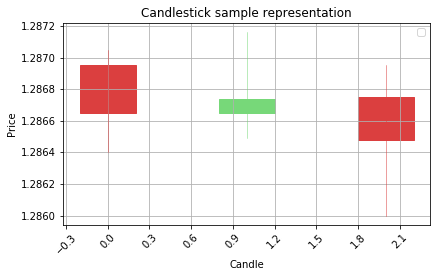

[0.56624883]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


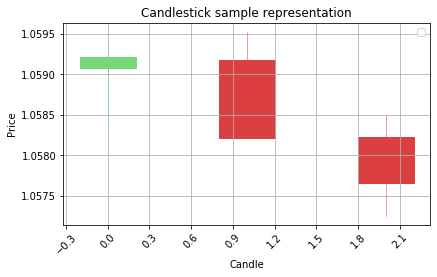

[0.55481076]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


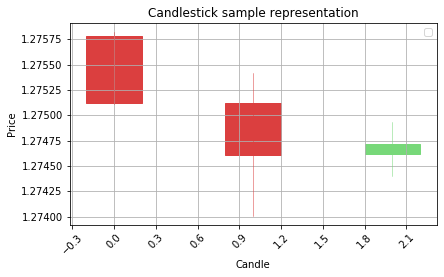

[0.55835503]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


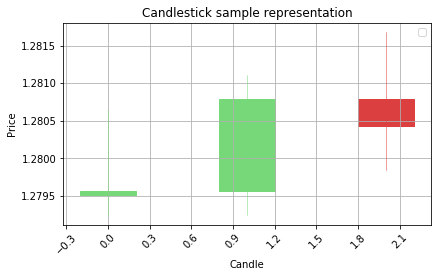

[0.56439924]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


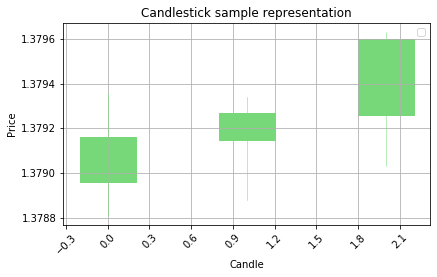

[0.57348835]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


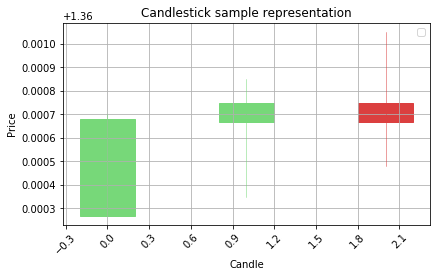

[0.55227226]

No handles with labels found to put in legend.



Correct prediction is Bearsih
Model prediction is Bearsih
WON


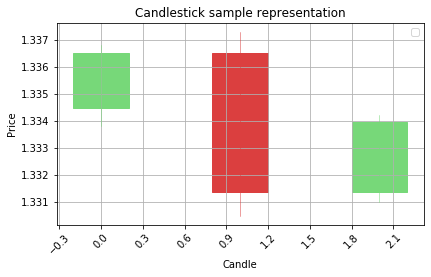

No handles with labels found to put in legend.


[0.5705525]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


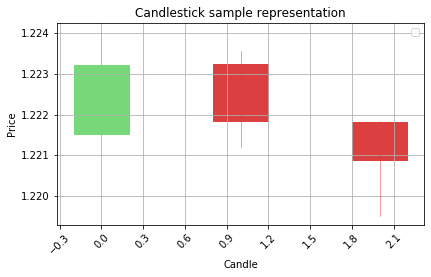

[0.55704886]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


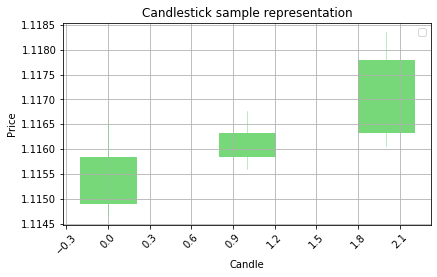

No handles with labels found to put in legend.


[0.5533708]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


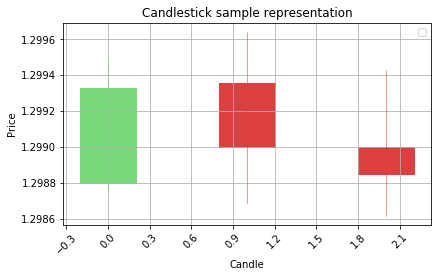

[0.56936324]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


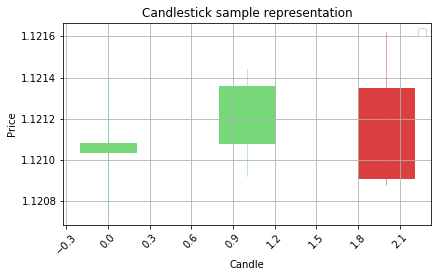

[0.5673188]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


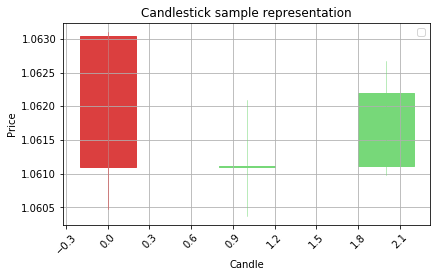

[0.5778153]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


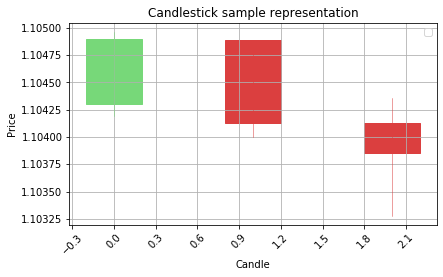

[0.5555832]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


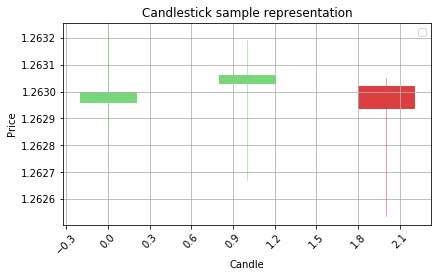

[0.56296533]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


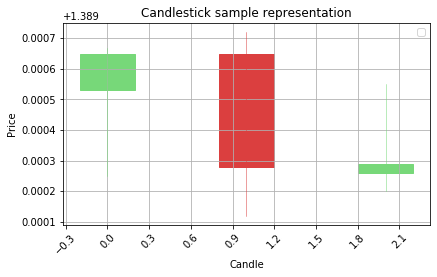

No handles with labels found to put in legend.


[0.55374527]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


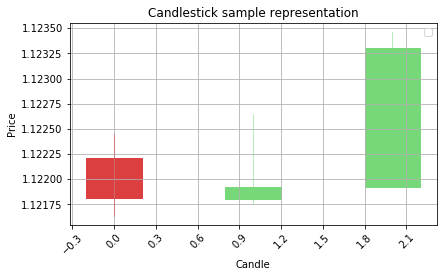

[0.5560278]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


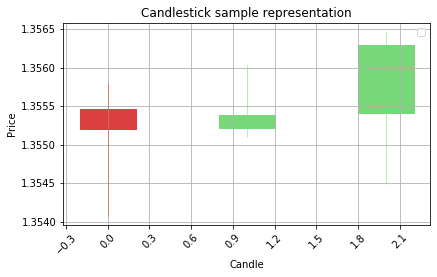

No handles with labels found to put in legend.


[0.5670855]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


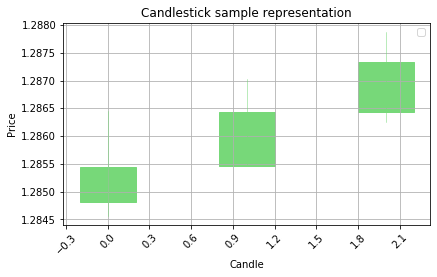

[0.55449784]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


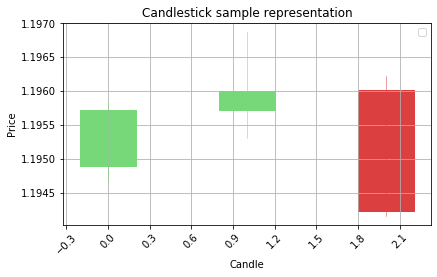

No handles with labels found to put in legend.


[0.55527294]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


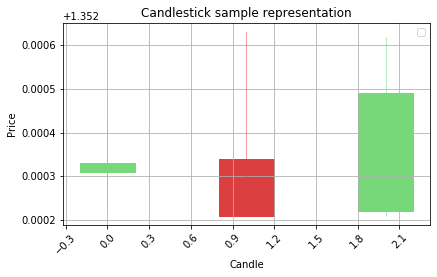

No handles with labels found to put in legend.


[0.57666653]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


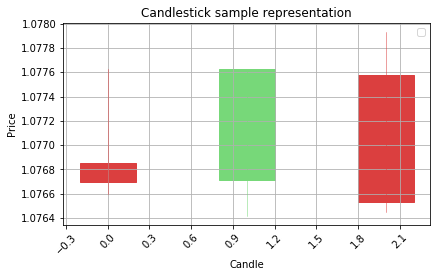

No handles with labels found to put in legend.


[0.5537621]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


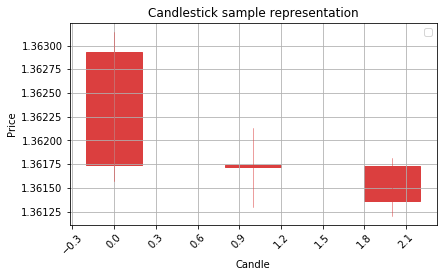

No handles with labels found to put in legend.


[0.562554]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


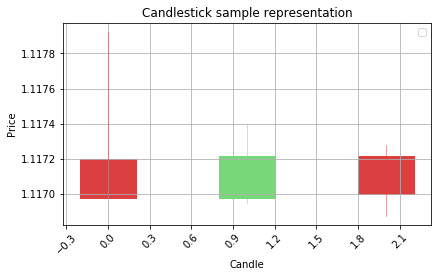

[0.55399203]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


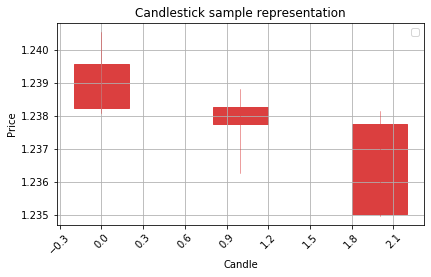

[0.55420727]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


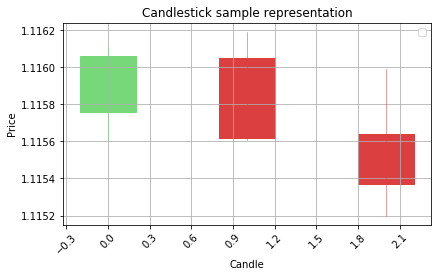

[0.55628085]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.57412946]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


No handles with labels found to put in legend.


[0.5502379]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


[0.5572726]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


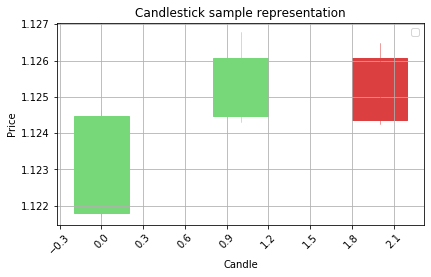

[0.55436933]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


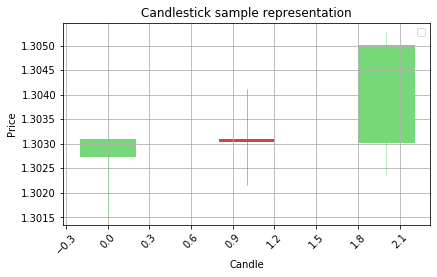

[0.55675375]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.556138]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


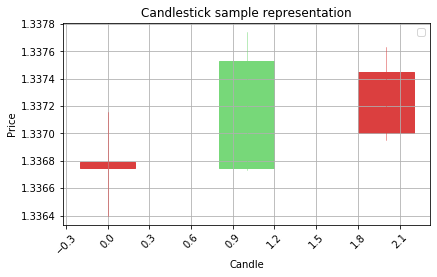

No handles with labels found to put in legend.


[0.5649969]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


[0.55696416]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


No handles with labels found to put in legend.


[0.577367]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


[0.5518098]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


[0.5734743]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.5614857]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


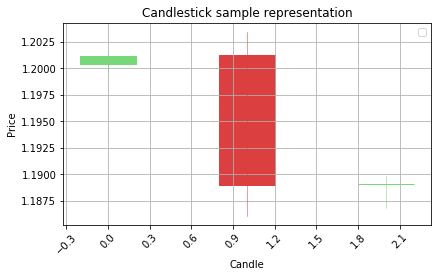

[0.5591729]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


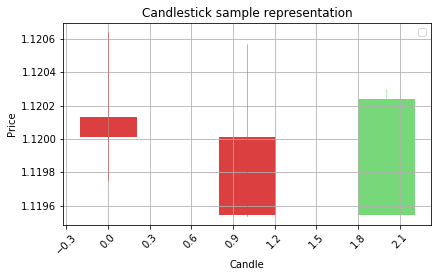

[0.56452143]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


[0.5591206]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.5584962]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


[0.5508934]

No handles with labels found to put in legend.



Correct prediction is Bearsih
Model prediction is Bearsih
WON


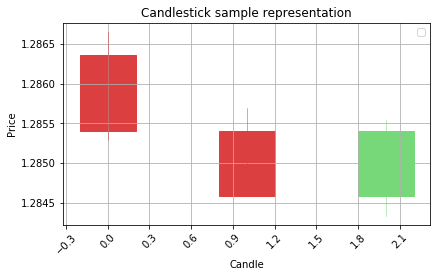

[0.55971646]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


No handles with labels found to put in legend.


[0.5526306]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


[0.5645615]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


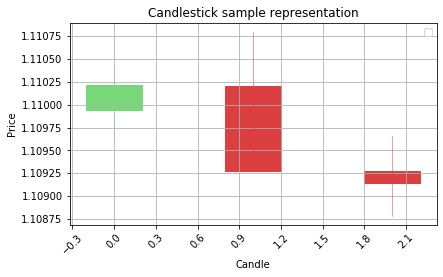

No handles with labels found to put in legend.


[0.5601556]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


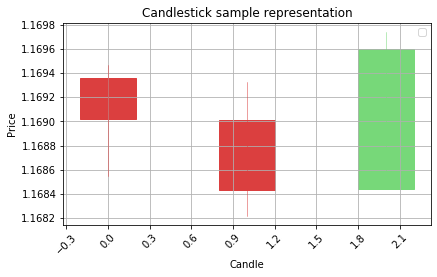

No handles with labels found to put in legend.


[0.57275516]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


[0.58085364]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


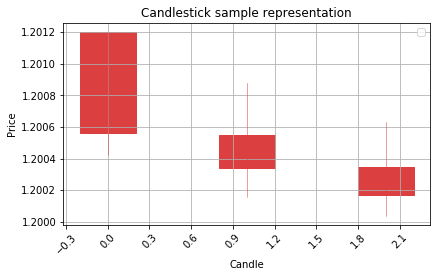

No handles with labels found to put in legend.


[0.5528812]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


[0.55102134]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


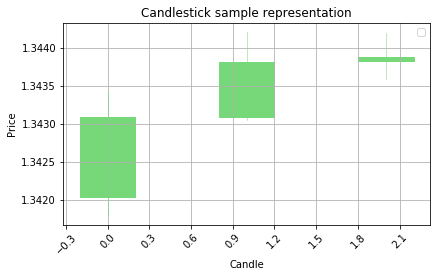

[0.55441135]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


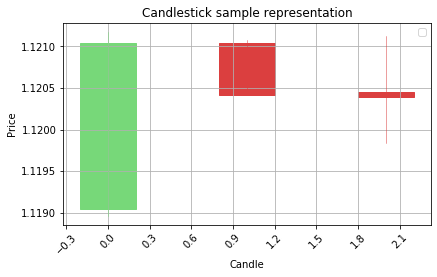

[0.5627639]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.55147463]

No handles with labels found to put in legend.



Correct prediction is Bearsih
Model prediction is Bearsih
WON


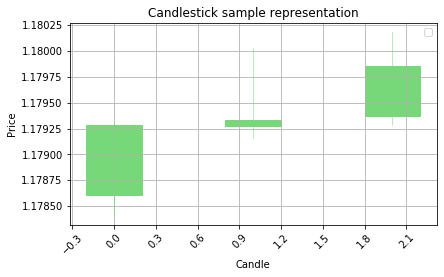

[0.5561623]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


[0.5559944]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


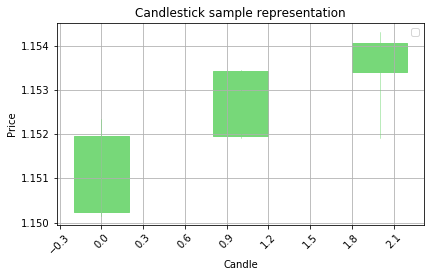

No handles with labels found to put in legend.


[0.566172]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


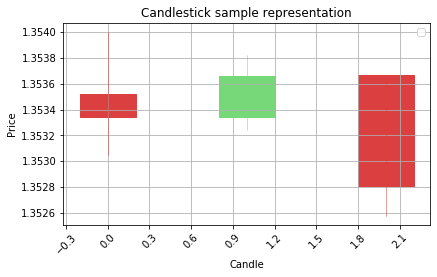

No handles with labels found to put in legend.


[0.5534552]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


[0.5506643]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


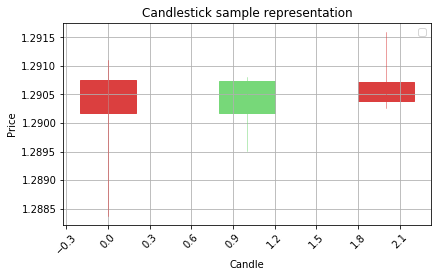

[0.57045615]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.5600616]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


No handles with labels found to put in legend.


[0.55022854]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


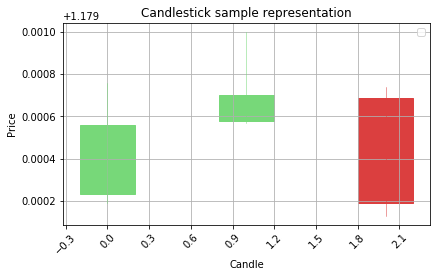

[0.5534542]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


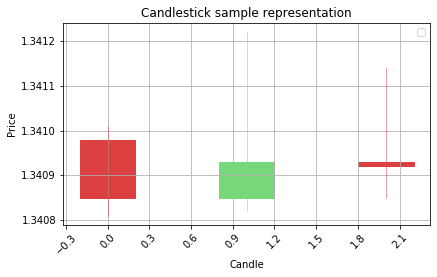

[0.56421006]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


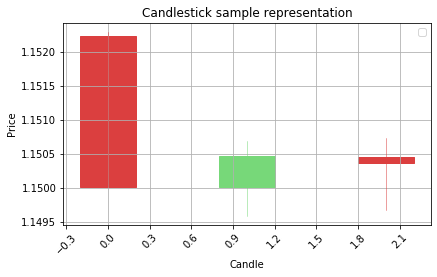

[0.5669214]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


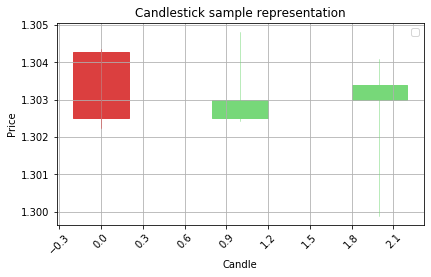

[0.5542471]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


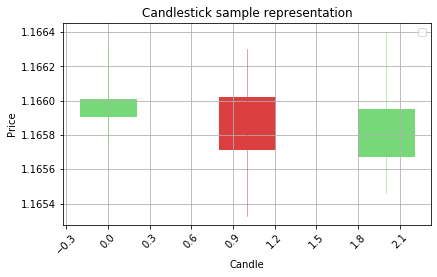

[0.5764642]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


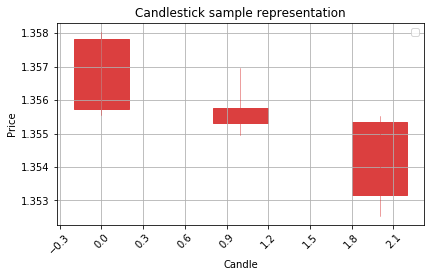

[0.5558518]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


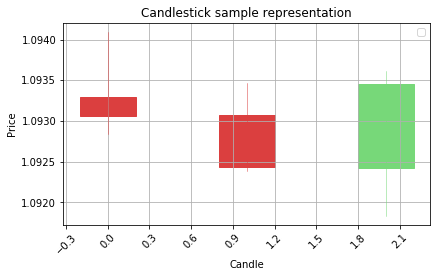

[0.5516701]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


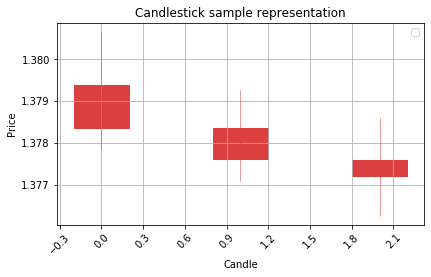

[0.5603308]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


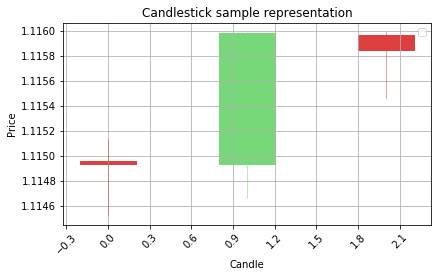

[0.5618502]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


No handles with labels found to put in legend.


[0.55138916]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


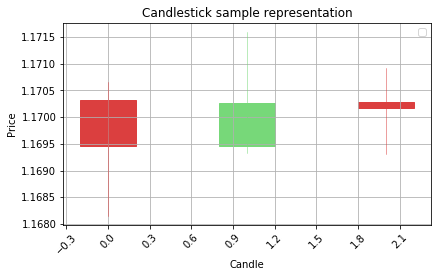

[0.56019783]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


No handles with labels found to put in legend.


[0.5613358]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


[0.5645643]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


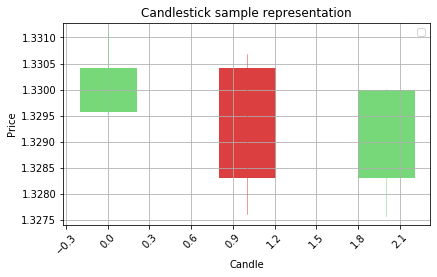

No handles with labels found to put in legend.


[0.56723374]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


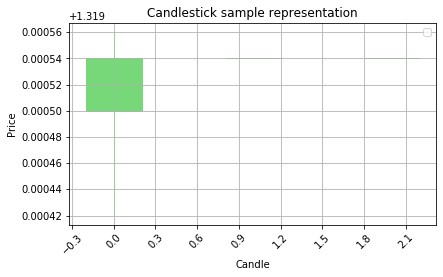

[0.572752]
Correct prediction is Bearsih
Model prediction is Bearsih

No handles with labels found to put in legend.



WON


No handles with labels found to put in legend.


[0.5669911]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


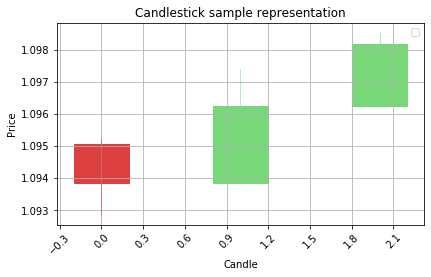

[0.55148536]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


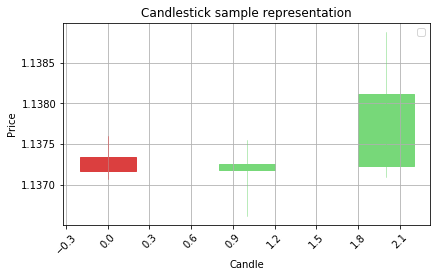

No handles with labels found to put in legend.


[0.5613004]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.57505906]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


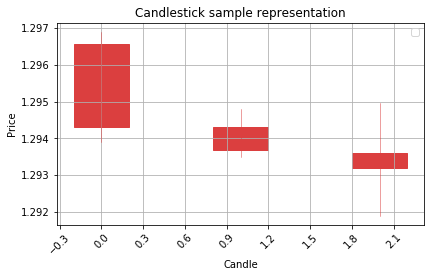

[0.57126695]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


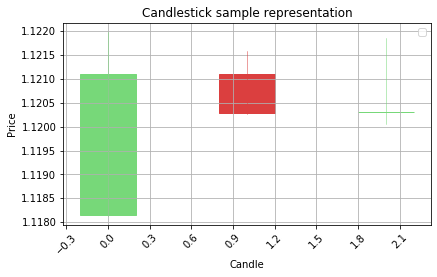

No handles with labels found to put in legend.


[0.5656747]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


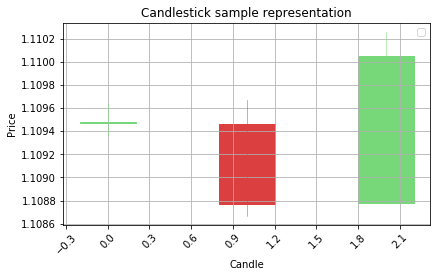

No handles with labels found to put in legend.


[0.5562164]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


[0.56318194]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


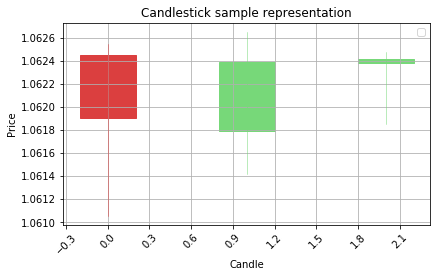

No handles with labels found to put in legend.


[0.56126076]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


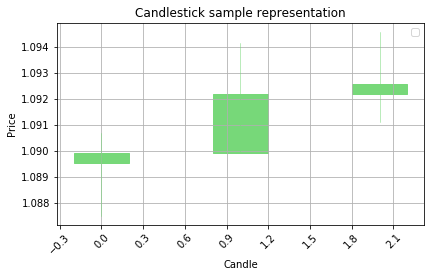

[0.56590587]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


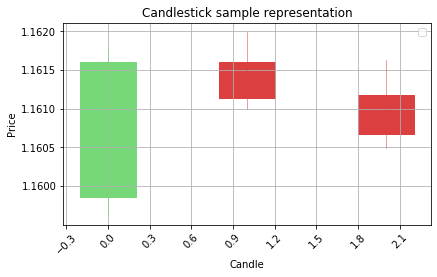

No handles with labels found to put in legend.


[0.5602149]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


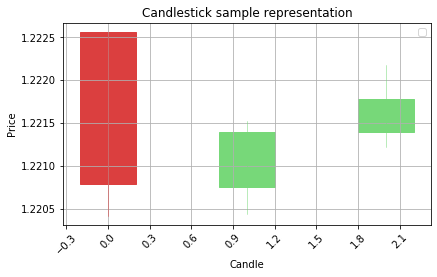

[0.5545522]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


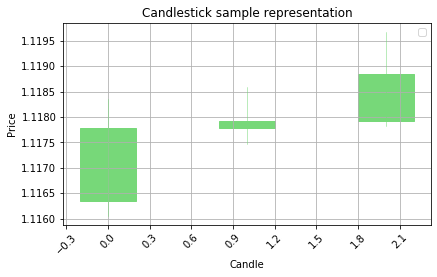

No handles with labels found to put in legend.


[0.5533303]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


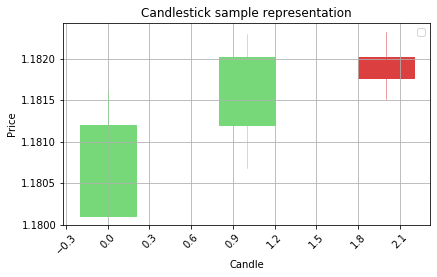

No handles with labels found to put in legend.


[0.563712]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


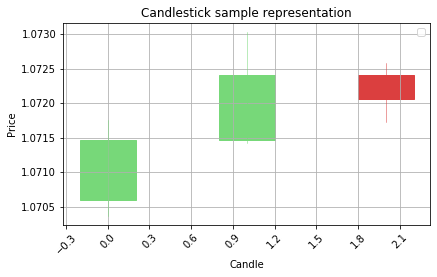

[0.57180595]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


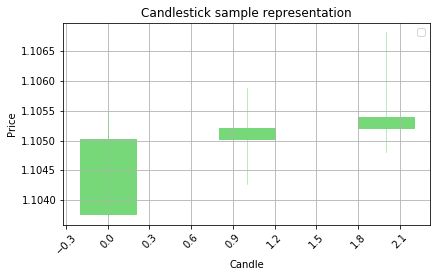

[0.5566012]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


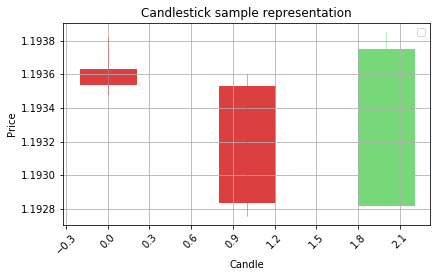

[0.56292325]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


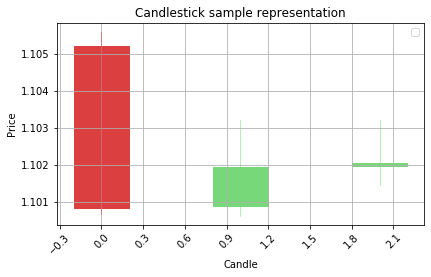

[0.5502314]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


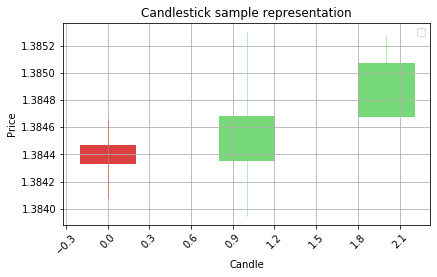

No handles with labels found to put in legend.


[0.56955737]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


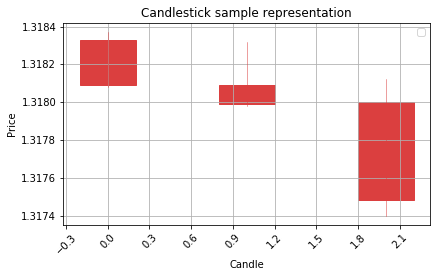

[0.5551651]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


No handles with labels found to put in legend.


[0.5527408]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


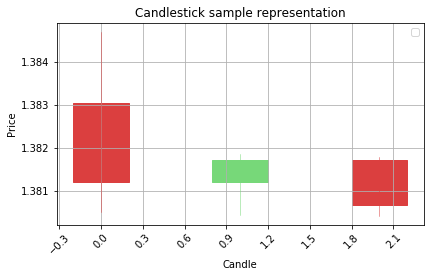

[0.55664974]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


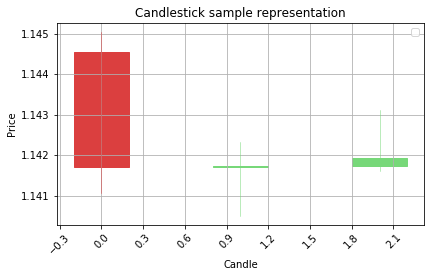

No handles with labels found to put in legend.


[0.55708206]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


[0.56122375]

No handles with labels found to put in legend.



Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.5504485]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


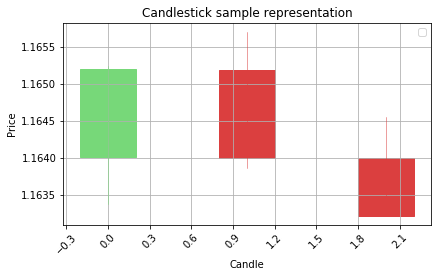

[0.57590973]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


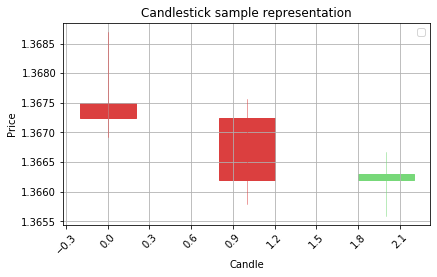

[0.5699811]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


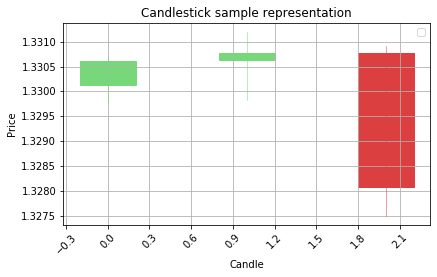

No handles with labels found to put in legend.


[0.5619094]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


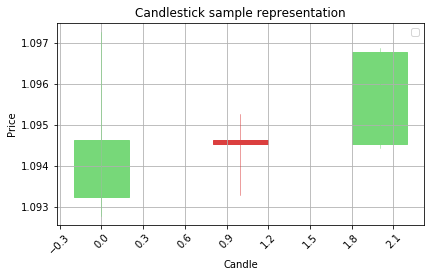

[0.56368905]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


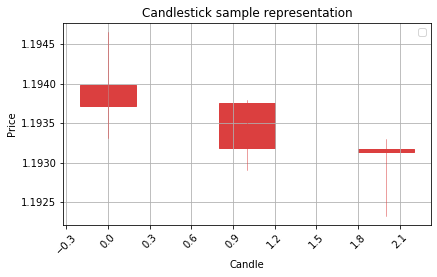

No handles with labels found to put in legend.


[0.5521439]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


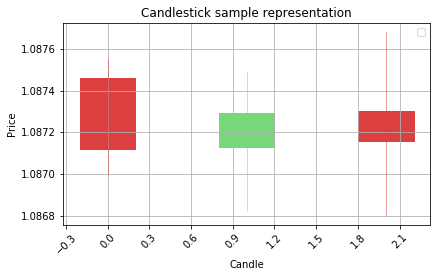

[0.55903137]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


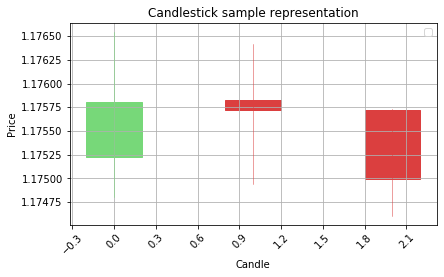

[0.55851567]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


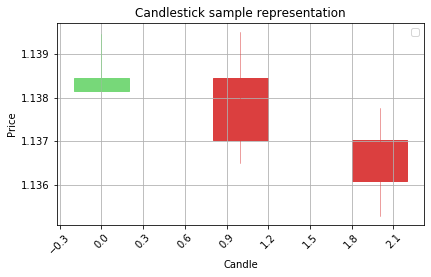

[0.5599565]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


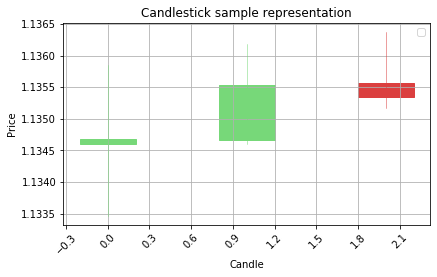

No handles with labels found to put in legend.


[0.5670817]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


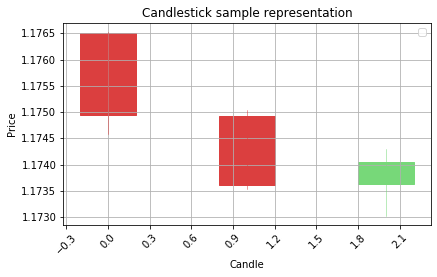

No handles with labels found to put in legend.


[0.5518613]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


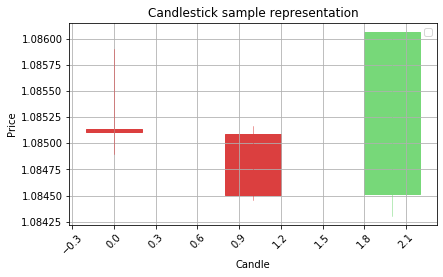

No handles with labels found to put in legend.


[0.5551345]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


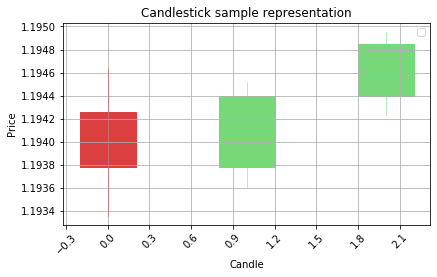

No handles with labels found to put in legend.


[0.5639621]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


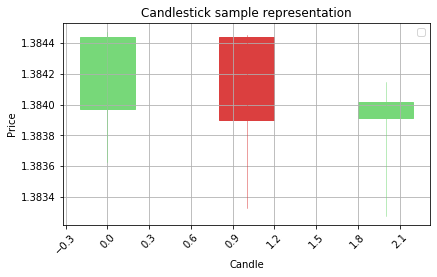

[0.56082445]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


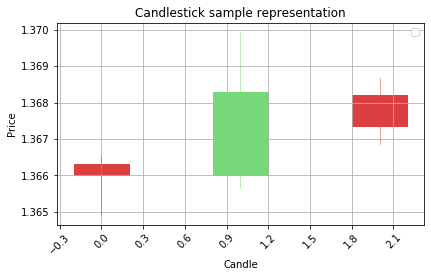

[0.5559186]

No handles with labels found to put in legend.



Correct prediction is Bullish
Model prediction is Bearsih
LOST


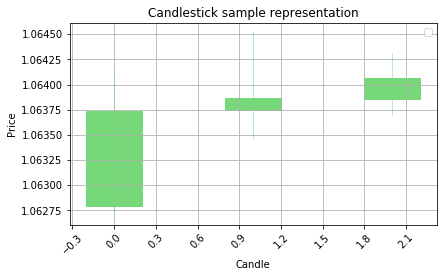

[0.5548266]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


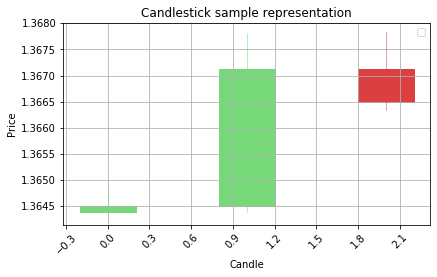

No handles with labels found to put in legend.


[0.56836784]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


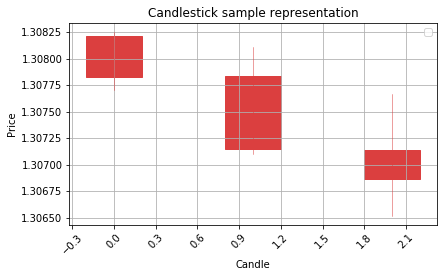

No handles with labels found to put in legend.


[0.55422145]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


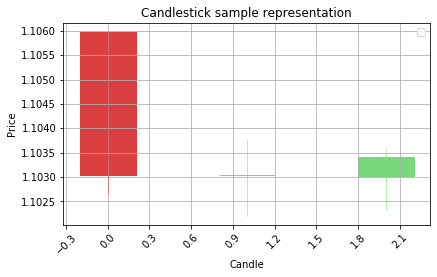

No handles with labels found to put in legend.


[0.5618978]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


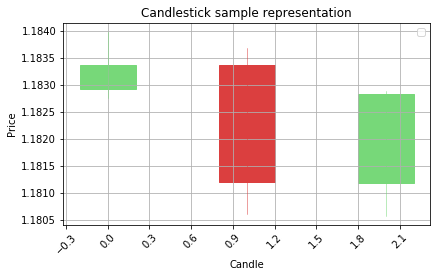

No handles with labels found to put in legend.


[0.56225127]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


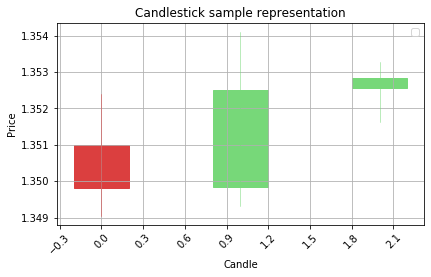

[0.5589044]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


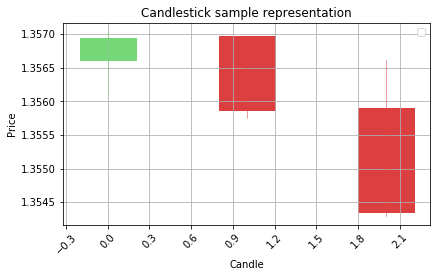

[0.56516904]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


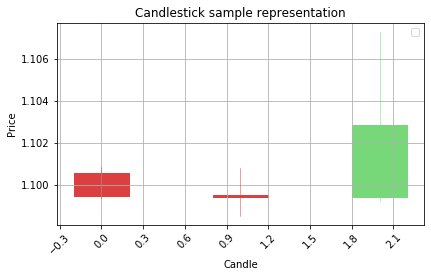

[0.56682414]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


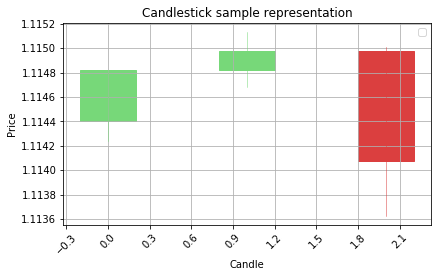

No handles with labels found to put in legend.


[0.55773735]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


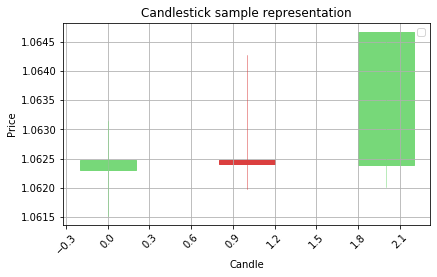

No handles with labels found to put in legend.


[0.5615036]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


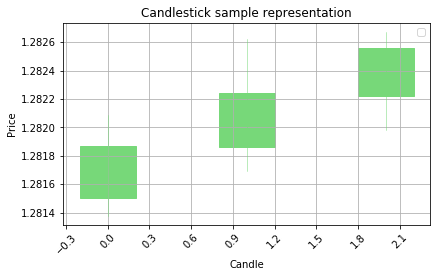

[0.5604849]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


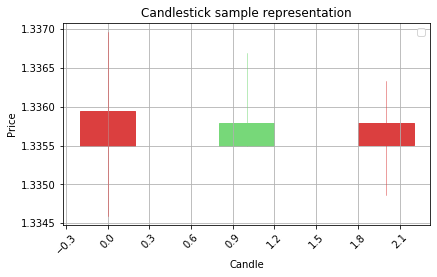

[0.55341417]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


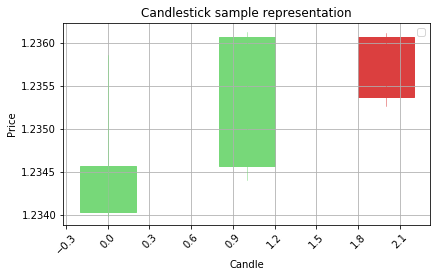

No handles with labels found to put in legend.


[0.5662729]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


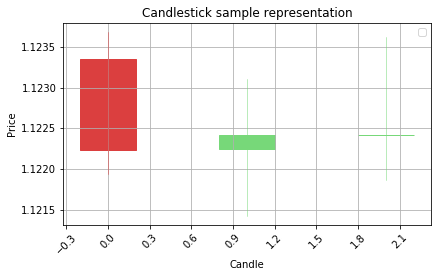

[0.5563281]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


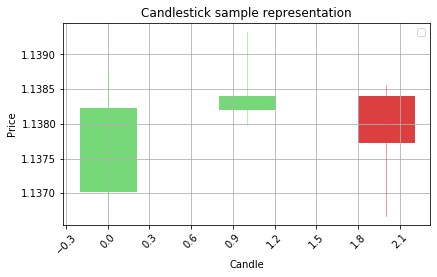

No handles with labels found to put in legend.


[0.5519979]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


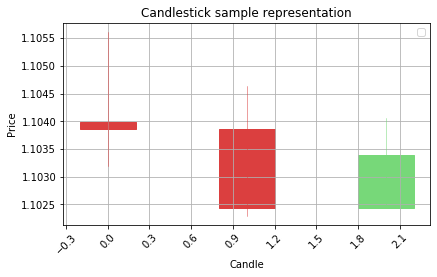

No handles with labels found to put in legend.


[0.55159587]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


[0.55629146]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


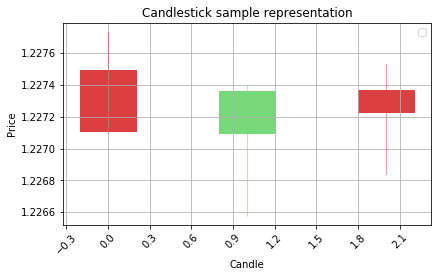

No handles with labels found to put in legend.


[0.55301046]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


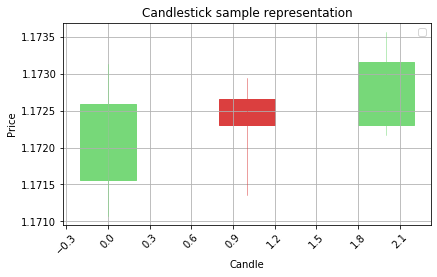

[0.550774]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


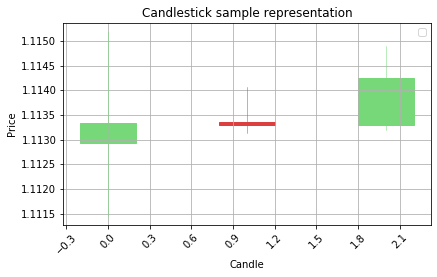

No handles with labels found to put in legend.


[0.5567507]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


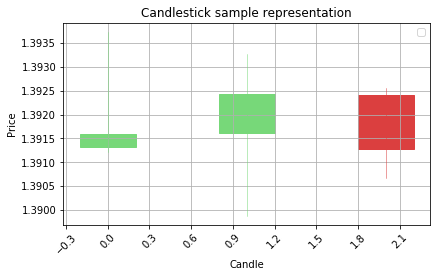

No handles with labels found to put in legend.


[0.56819797]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


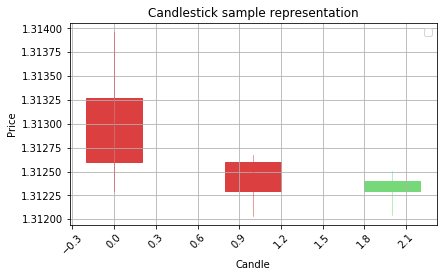

No handles with labels found to put in legend.


[0.55629146]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


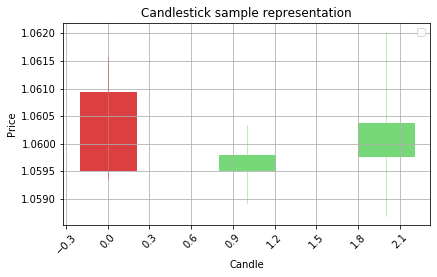

No handles with labels found to put in legend.


[0.5554835]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


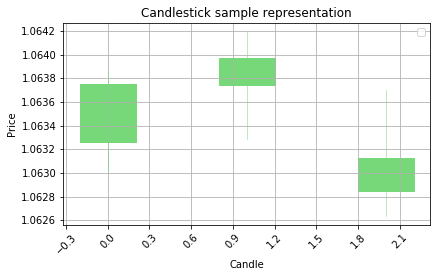

No handles with labels found to put in legend.


[0.55978525]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


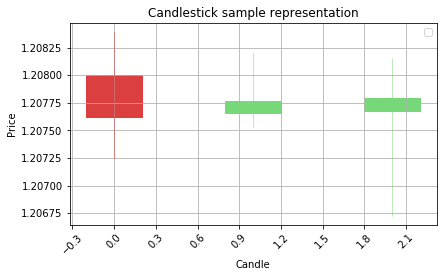

[0.55833954]

No handles with labels found to put in legend.



Correct prediction is Bullish
Model prediction is Bearsih
LOST


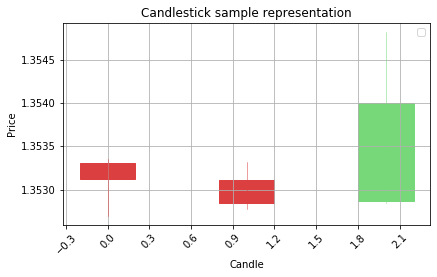

[0.5503632]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


[0.5577406]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


[0.5541892]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


No handles with labels found to put in legend.


[0.5609852]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


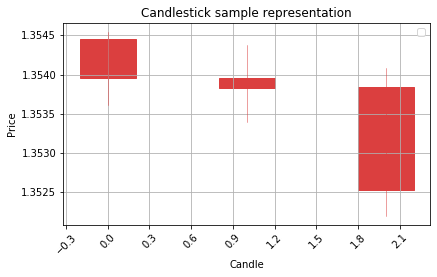

[0.5726595]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


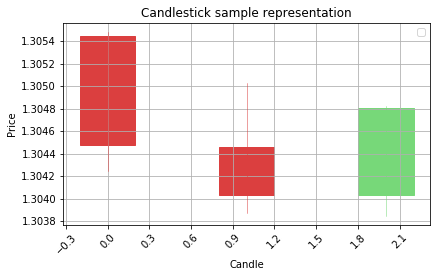

No handles with labels found to put in legend.


[0.5525121]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


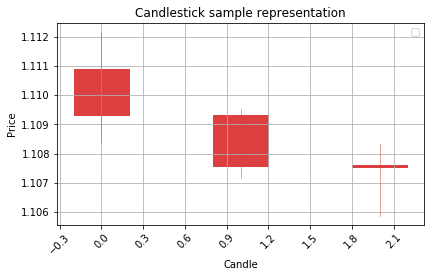

[0.551267]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


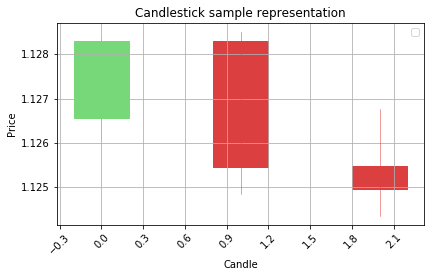

No handles with labels found to put in legend.


[0.55804724]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


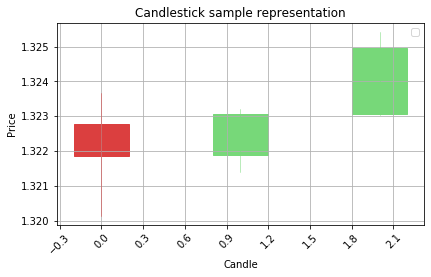

[0.5563234]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


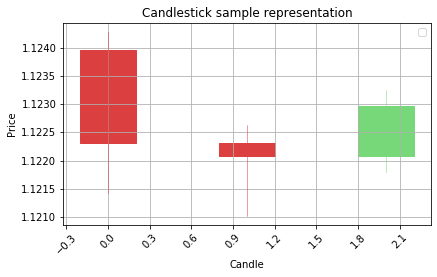

[0.5530831]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


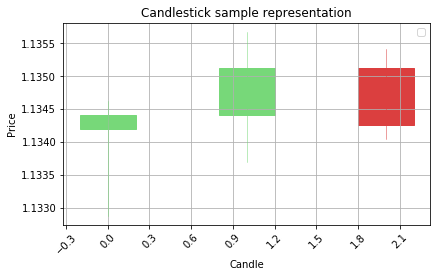

[0.56721246]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


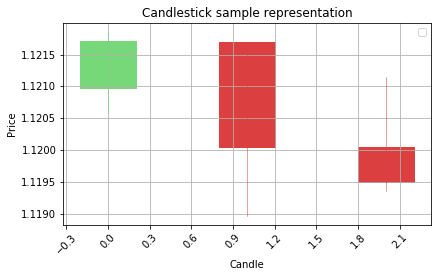

[0.5734586]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


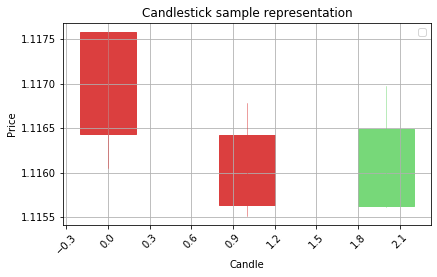

[0.5519826]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


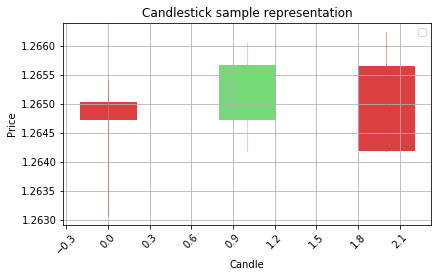

[0.5557022]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


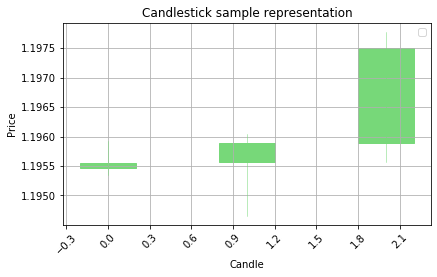

[0.5581819]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


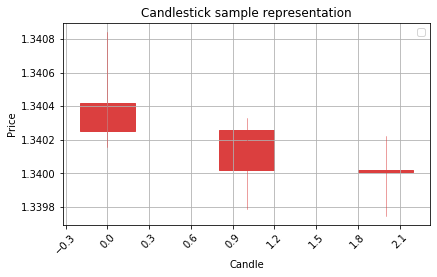

No handles with labels found to put in legend.


[0.55736446]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


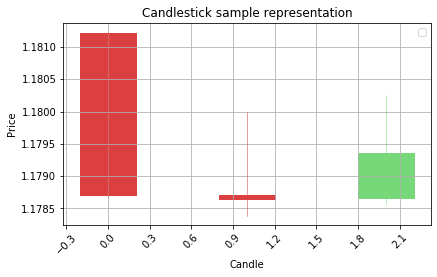

[0.5515995]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


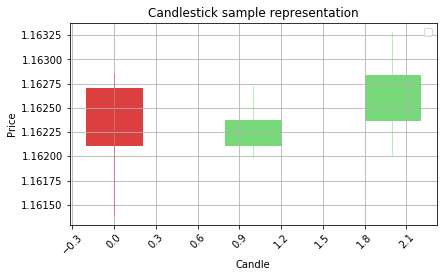

No handles with labels found to put in legend.


[0.5624971]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


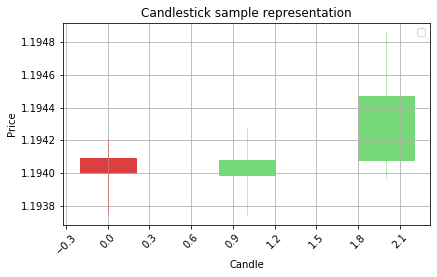

[0.5569615]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


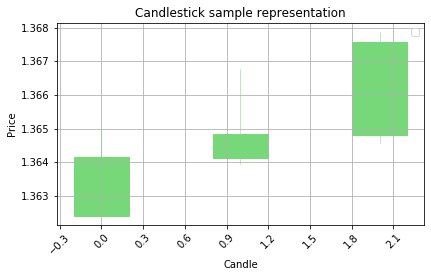

[0.5664551]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


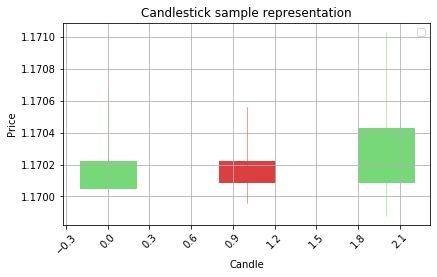

[0.56354195]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


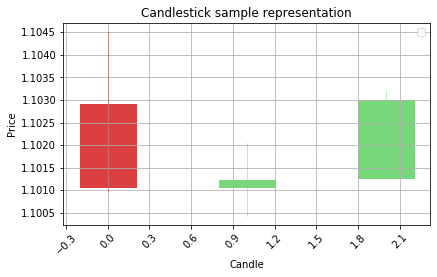

No handles with labels found to put in legend.


[0.5504365]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


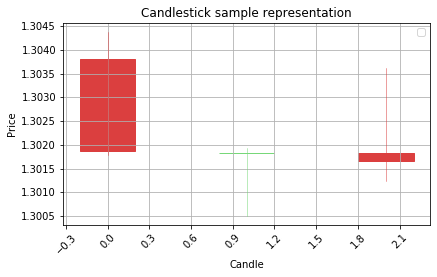

[0.55385923]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


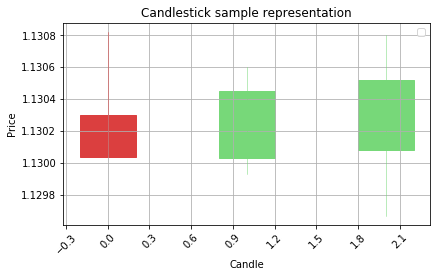

No handles with labels found to put in legend.


[0.57192963]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


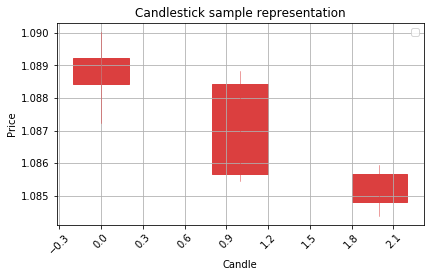

[0.5523175]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


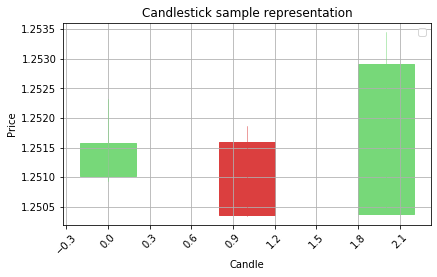

No handles with labels found to put in legend.


[0.56329876]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


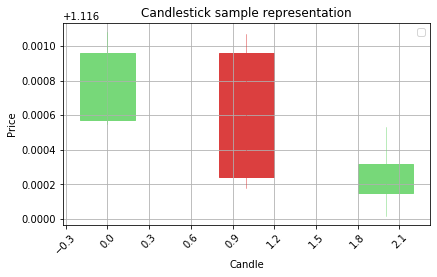

[0.5560894]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


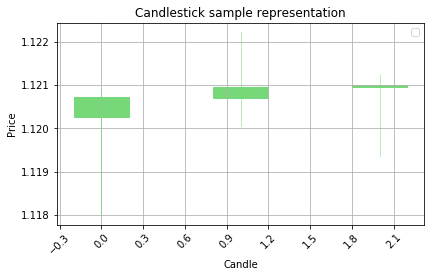

[0.5728697]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


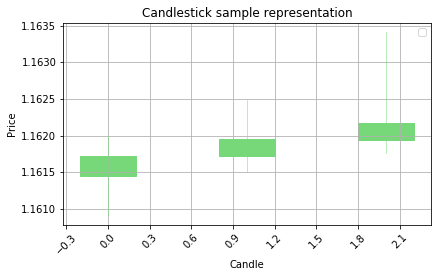

No handles with labels found to put in legend.


[0.5587758]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


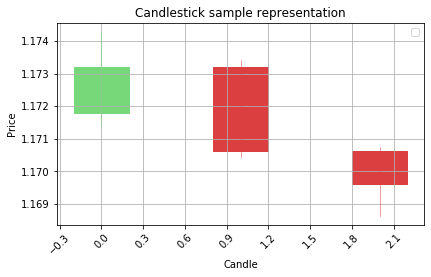

[0.55143493]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


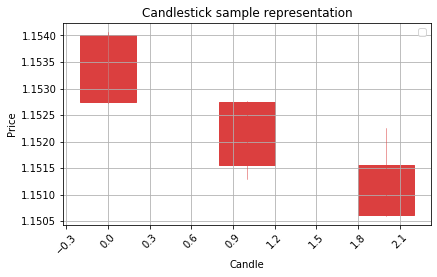

No handles with labels found to put in legend.


[0.55860126]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


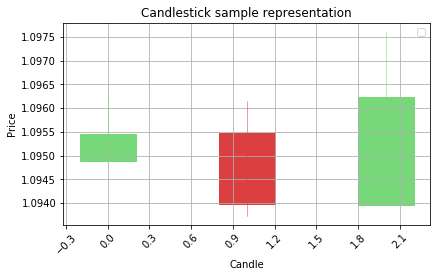

No handles with labels found to put in legend.


[0.55227244]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


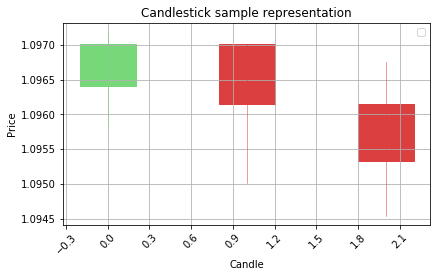

No handles with labels found to put in legend.


[0.55538994]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


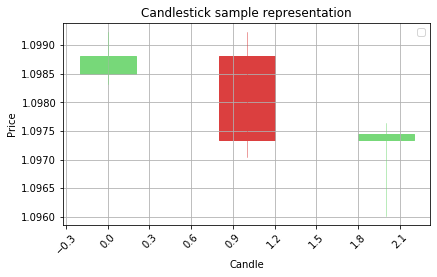

[0.55682176]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


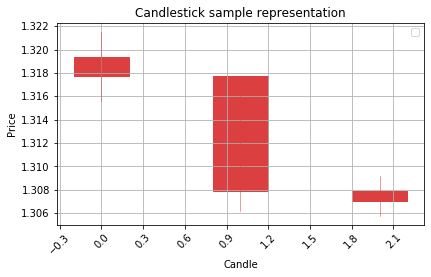

No handles with labels found to put in legend.


[0.5571069]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


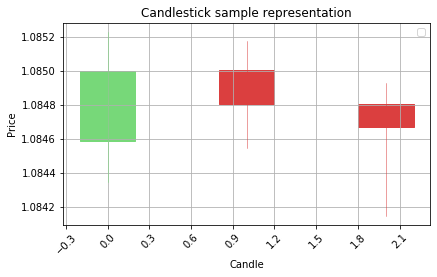

[0.5572324]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


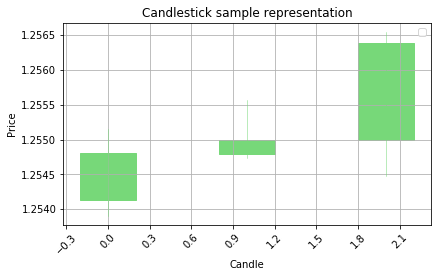

No handles with labels found to put in legend.


[0.56930685]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


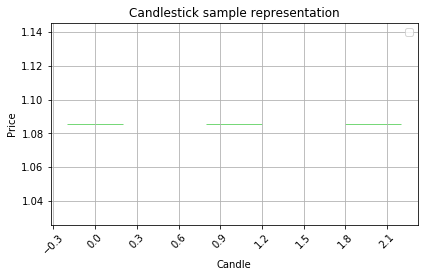

[0.55310136]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


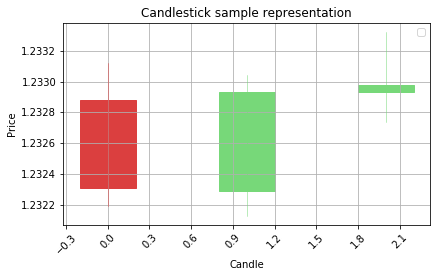

No handles with labels found to put in legend.


[0.55197215]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


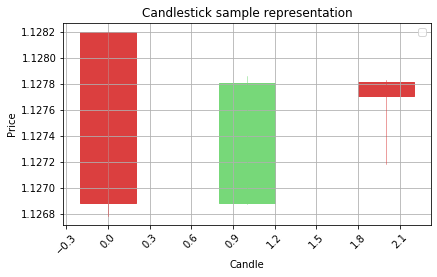

No handles with labels found to put in legend.


[0.5579968]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


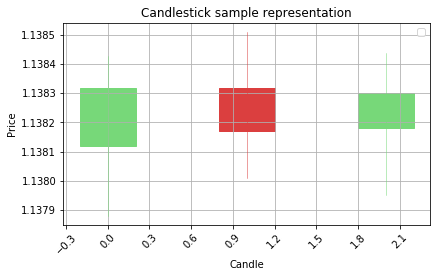

No handles with labels found to put in legend.


[0.5591092]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


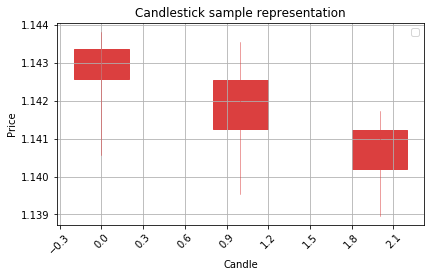

No handles with labels found to put in legend.


[0.57010716]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


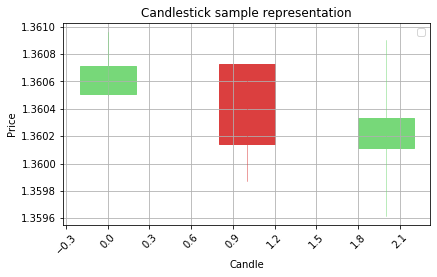

[0.55071956]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


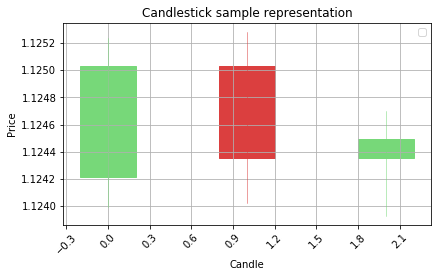

No handles with labels found to put in legend.


[0.5571601]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


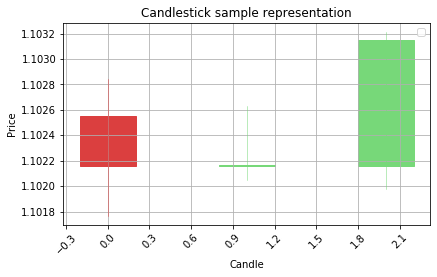

No handles with labels found to put in legend.


[0.5527016]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


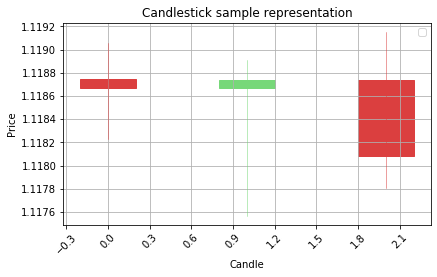

No handles with labels found to put in legend.


[0.55595577]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


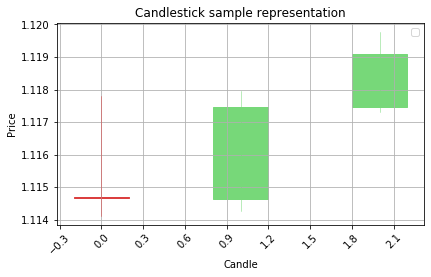

[0.5741325]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


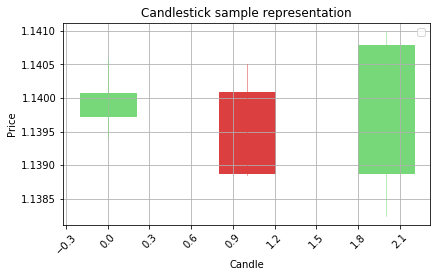

No handles with labels found to put in legend.


[0.55540925]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


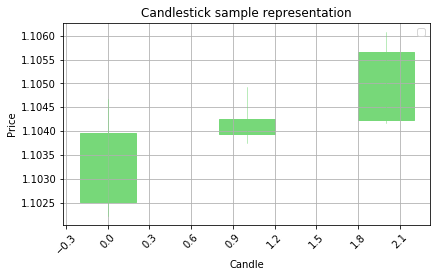

No handles with labels found to put in legend.


[0.5582578]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


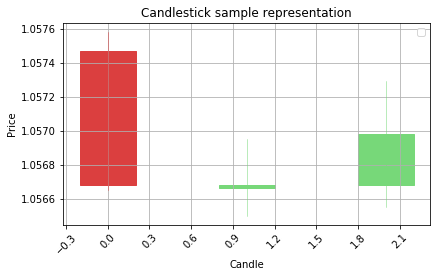

[0.5555119]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


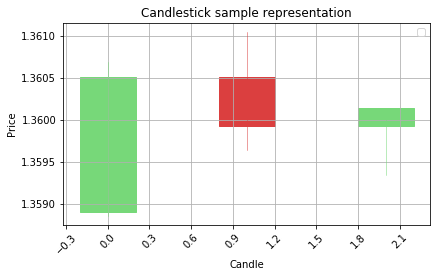

No handles with labels found to put in legend.


[0.5504872]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


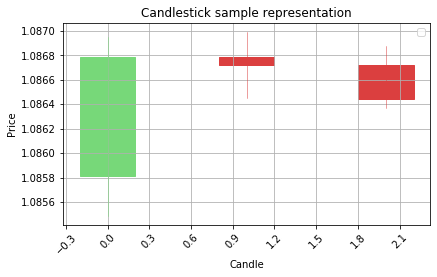

[0.55824053]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


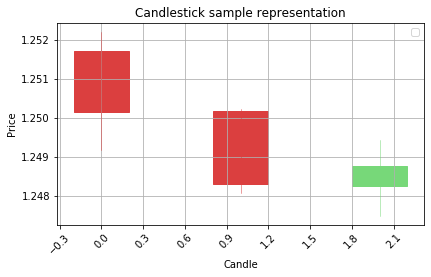

[0.559731]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


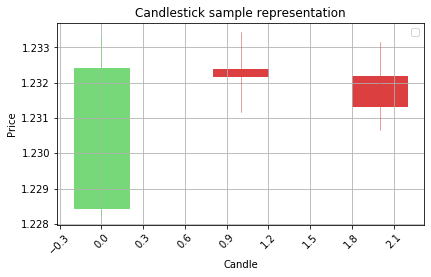

No handles with labels found to put in legend.


[0.5538617]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


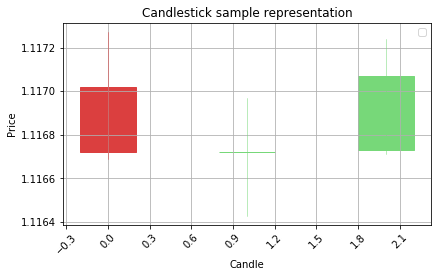

[0.55082166]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


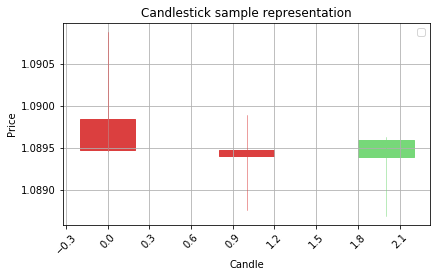

[0.55754626]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


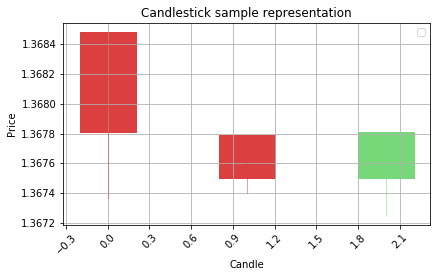

No handles with labels found to put in legend.


[0.559312]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


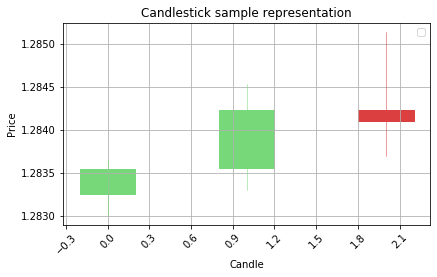

[0.55421185]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


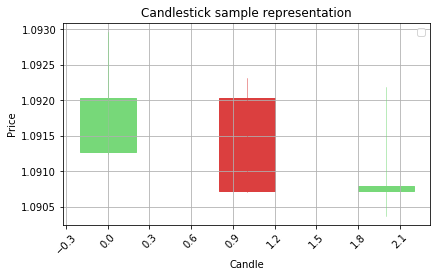

No handles with labels found to put in legend.


[0.56675416]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


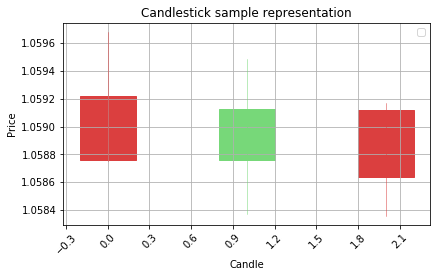

No handles with labels found to put in legend.


[0.55609876]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


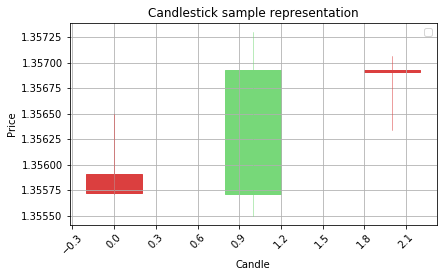

No handles with labels found to put in legend.


[0.55783856]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


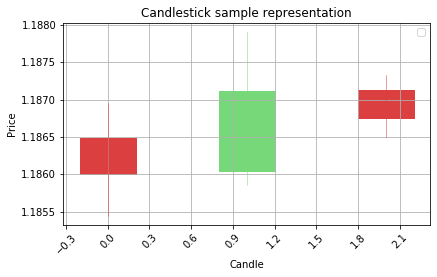

[0.5654516]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


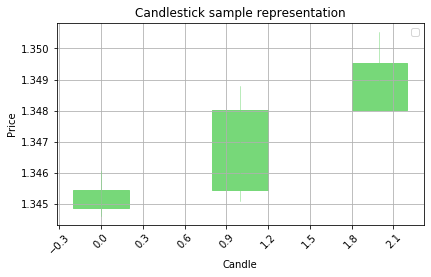

[0.550519]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


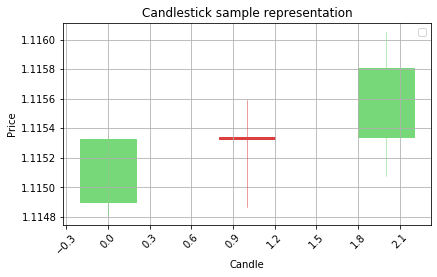

No handles with labels found to put in legend.


[0.5635651]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


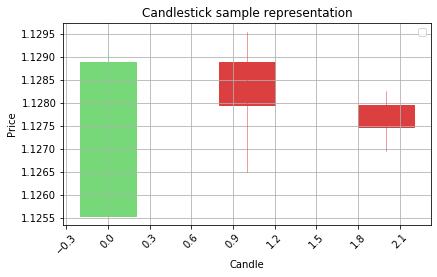

No handles with labels found to put in legend.


[0.5574005]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


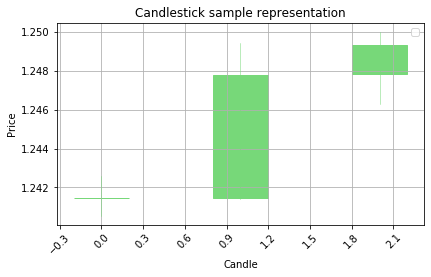

[0.56096774]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


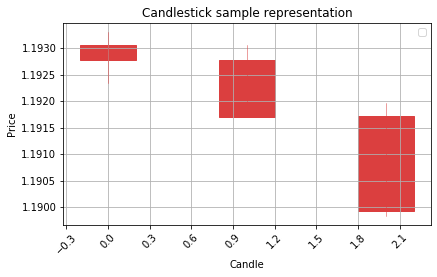

No handles with labels found to put in legend.


[0.5719809]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


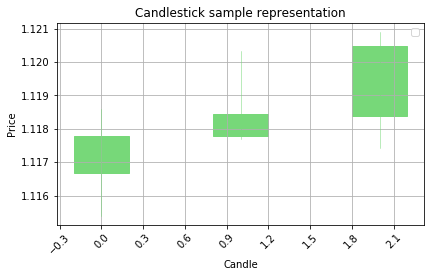

[0.55008304]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


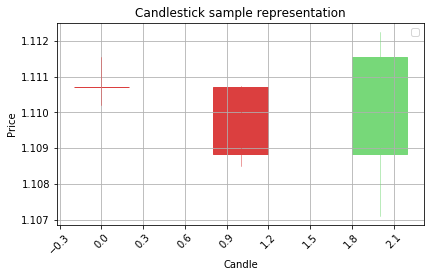

[0.56557536]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


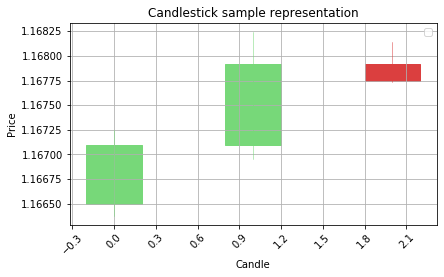

No handles with labels found to put in legend.


[0.5517796]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


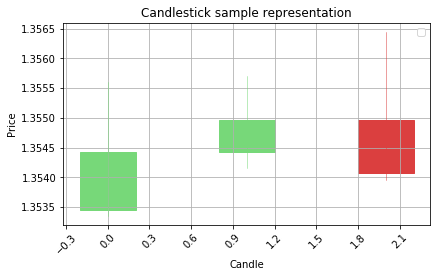

[0.55042225]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


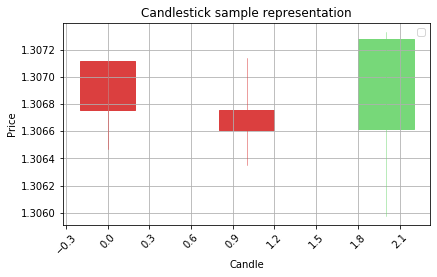

No handles with labels found to put in legend.


[0.5513338]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


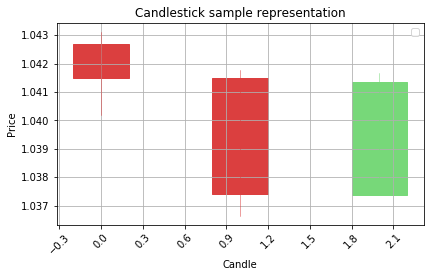

[0.5668328]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


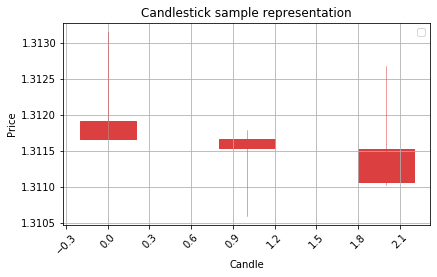

[0.5534622]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


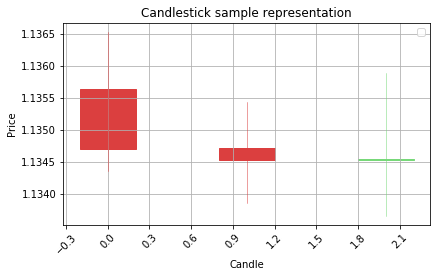

[0.552557]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


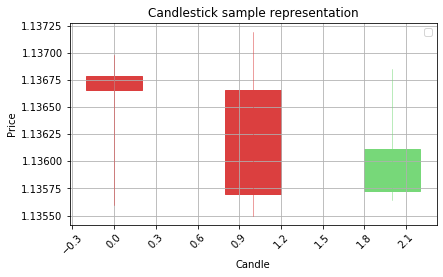

[0.5551169]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


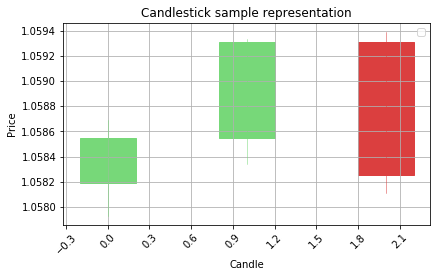

No handles with labels found to put in legend.


[0.5664675]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


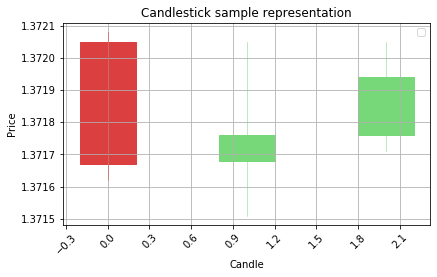

[0.55973285]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


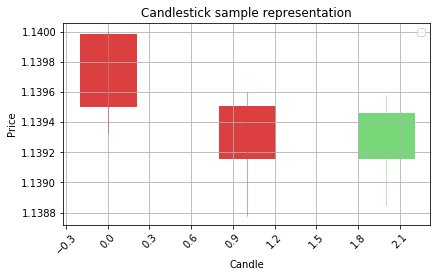

[0.55919635]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


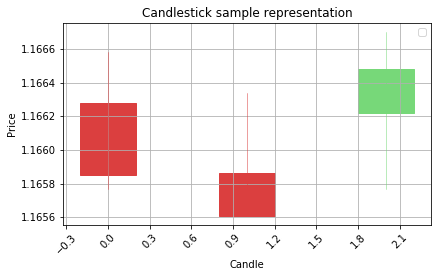

[0.5674341]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


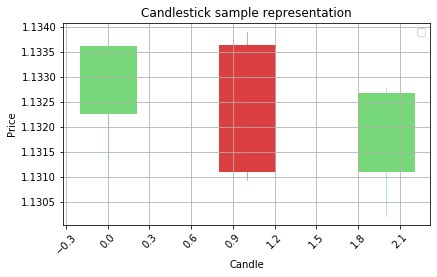

No handles with labels found to put in legend.


[0.56466544]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


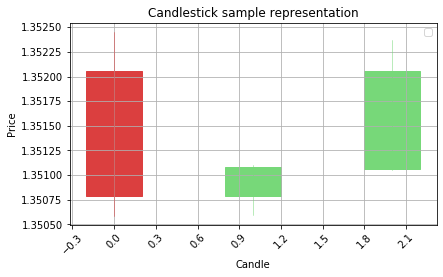

No handles with labels found to put in legend.


[0.5569431]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


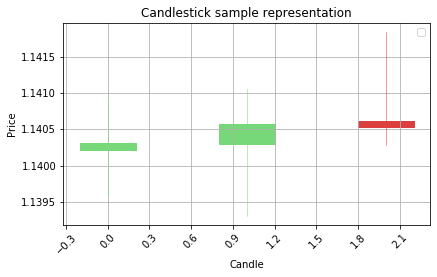

[0.56895494]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


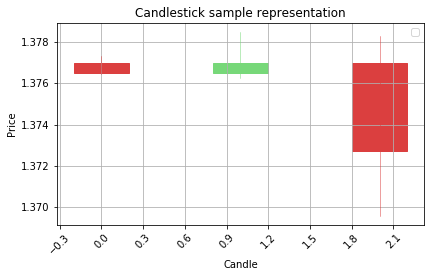

[0.56143695]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


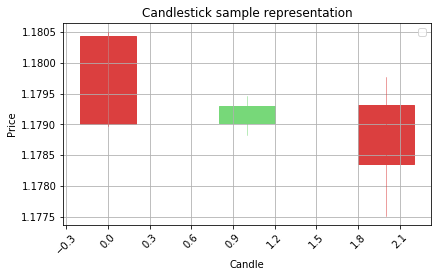

[0.5536118]
Correct prediction is Bullish
Model prediction is Bearsih


No handles with labels found to put in legend.


LOST


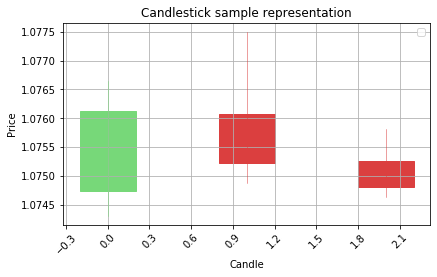

[0.5668498]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


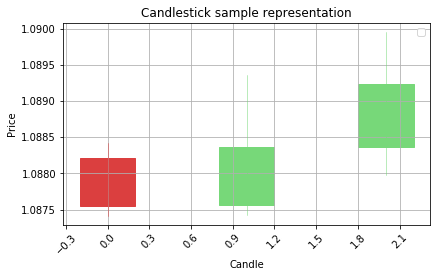

[0.55851364]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


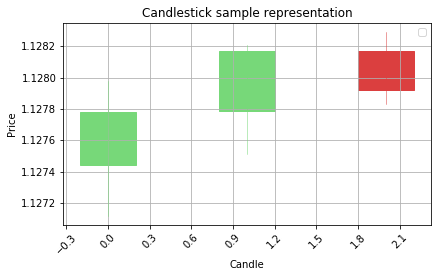

[0.56877375]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


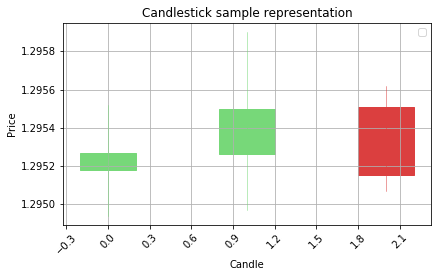

No handles with labels found to put in legend.


[0.56217235]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


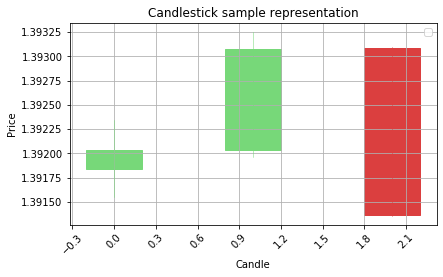

No handles with labels found to put in legend.


[0.555575]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


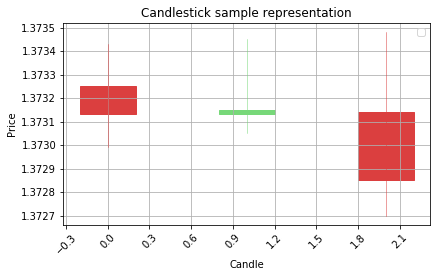

No handles with labels found to put in legend.


[0.5626056]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


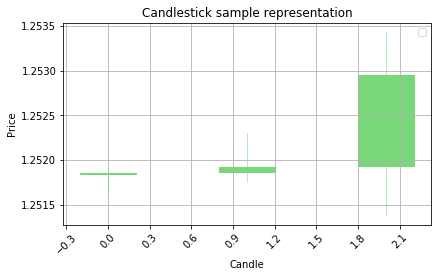

[0.551334]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


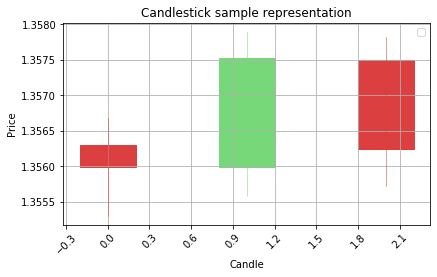

No handles with labels found to put in legend.


[0.56822085]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


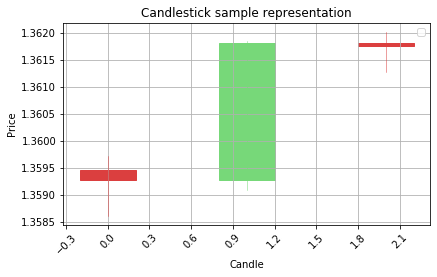

No handles with labels found to put in legend.


[0.5573546]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


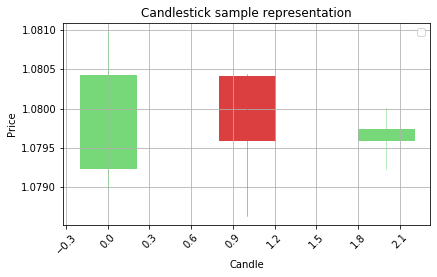

No handles with labels found to put in legend.


[0.55109096]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


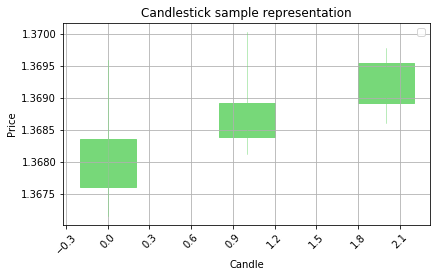

[0.5626157]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


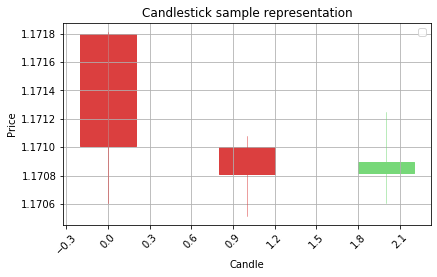

No handles with labels found to put in legend.


[0.55796486]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


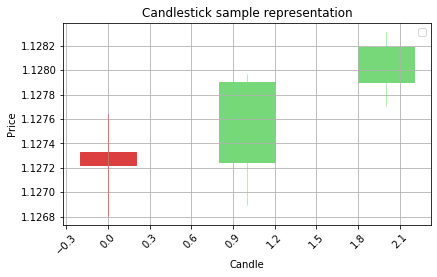

No handles with labels found to put in legend.


[0.5578934]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


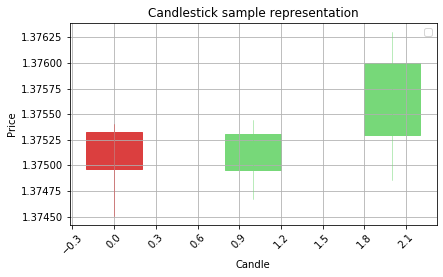

[0.56013036]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


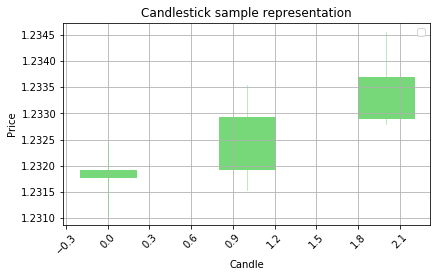

No handles with labels found to put in legend.


[0.5516687]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


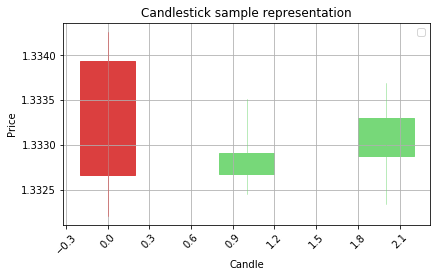

[0.5649357]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


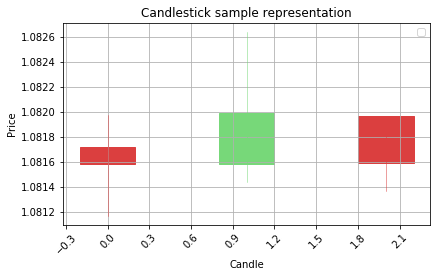

No handles with labels found to put in legend.


[0.5506214]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


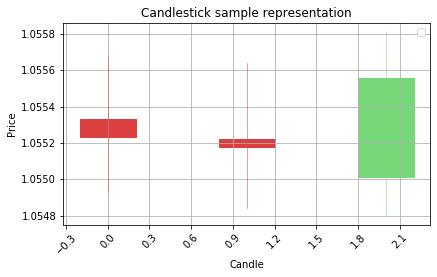

[0.56847245]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


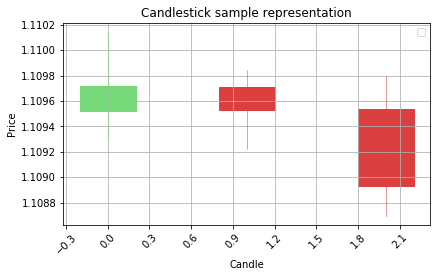

No handles with labels found to put in legend.


[0.5547501]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


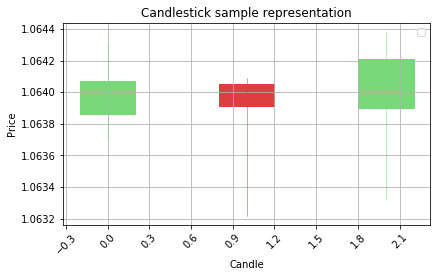

[0.55378765]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


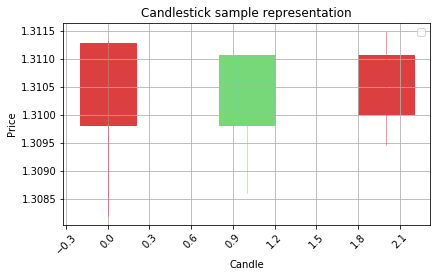

No handles with labels found to put in legend.


[0.5523006]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


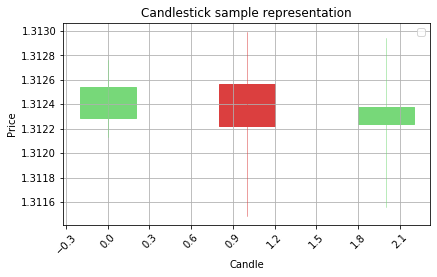

No handles with labels found to put in legend.


[0.5650555]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


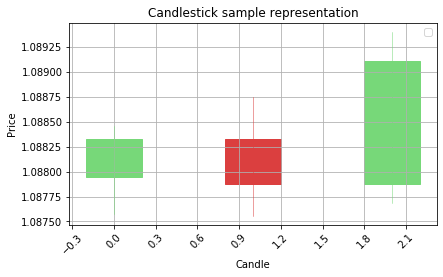

No handles with labels found to put in legend.


[0.5500242]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


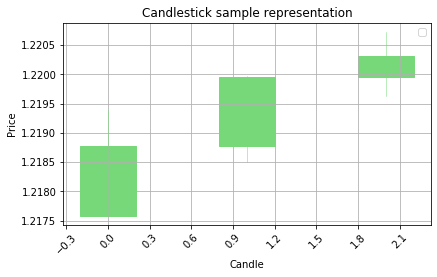

No handles with labels found to put in legend.


[0.5606915]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


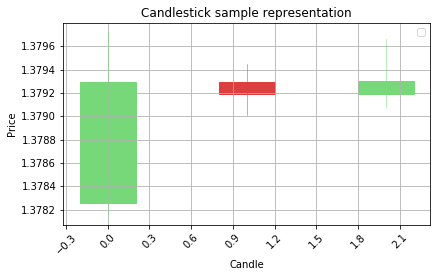

No handles with labels found to put in legend.


[0.55723137]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


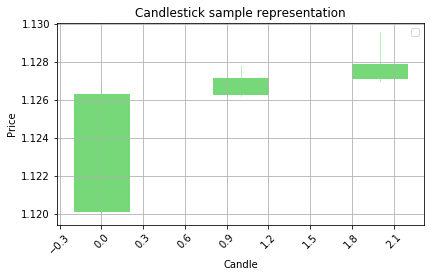

[0.550242]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


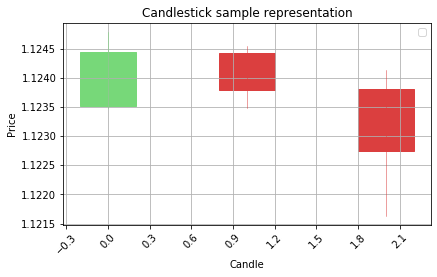

[0.5513262]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


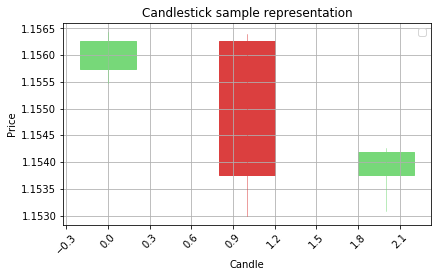

No handles with labels found to put in legend.


[0.5749985]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


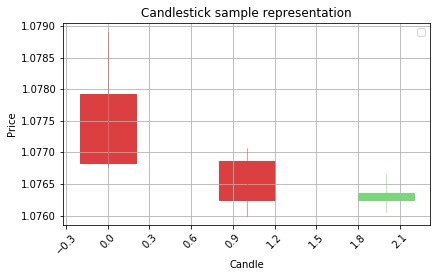

[0.55209994]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


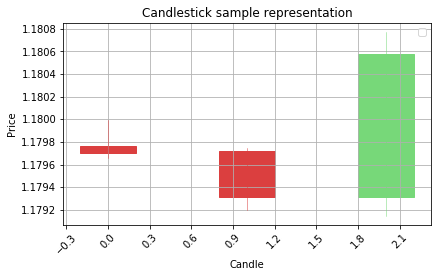

No handles with labels found to put in legend.


[0.5610973]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


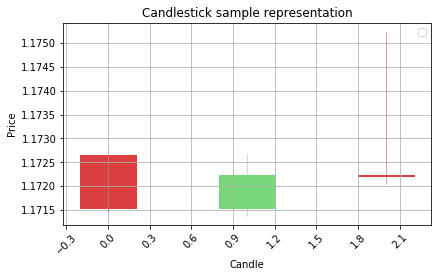

[0.5530502]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


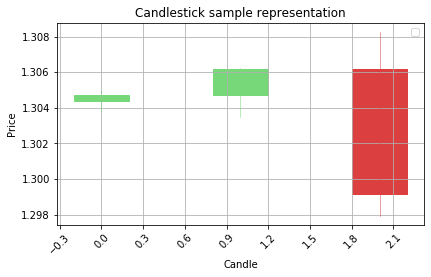

[0.5626106]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


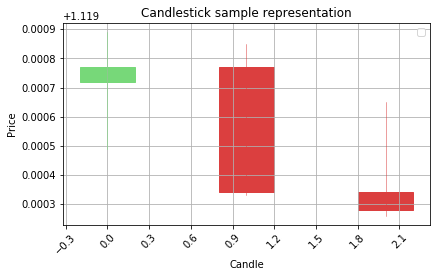

[0.56510925]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


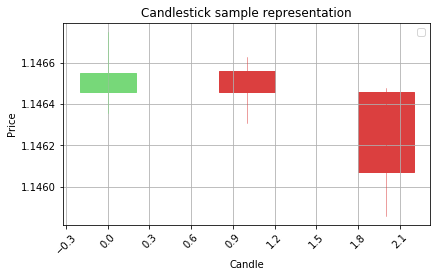

[0.5545069]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


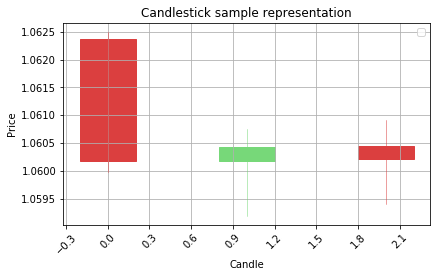

[0.561272]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


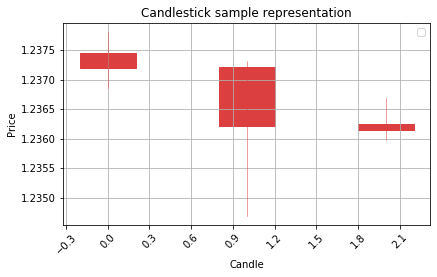

[0.5575931]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


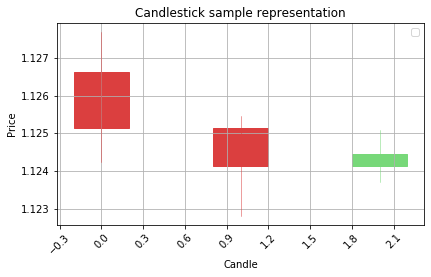

[0.55517286]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


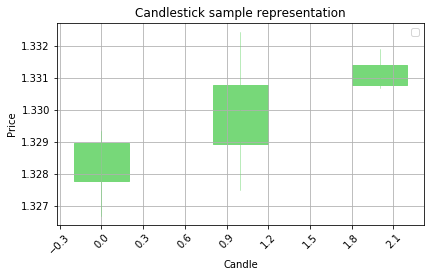

[0.5694548]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


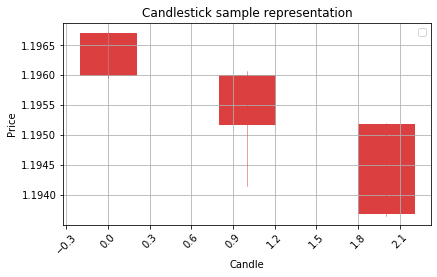

[0.5575069]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


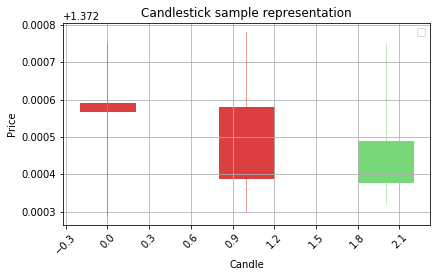

[0.56731135]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


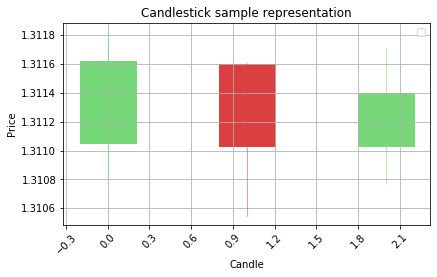

[0.568699]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


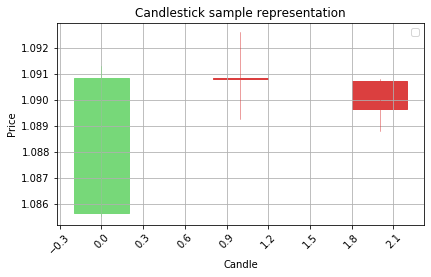

No handles with labels found to put in legend.


[0.56671345]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


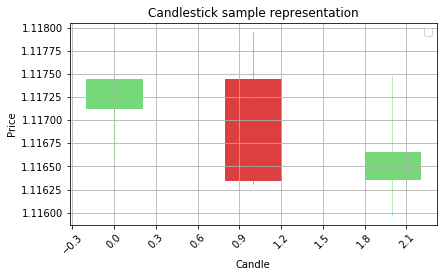

No handles with labels found to put in legend.


[0.5658265]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


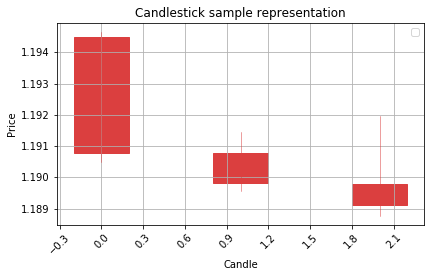

[0.5688686]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


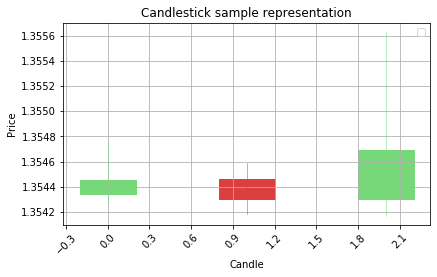

No handles with labels found to put in legend.


[0.55131364]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


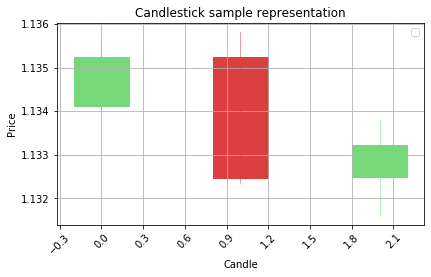

[0.5513724]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


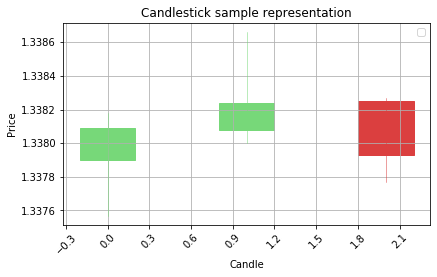

No handles with labels found to put in legend.


[0.55775243]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


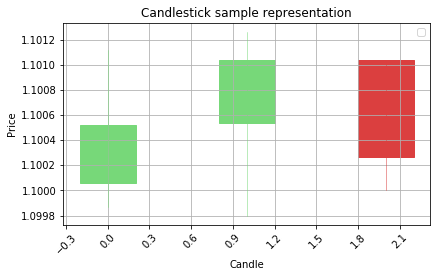

No handles with labels found to put in legend.


[0.56037736]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


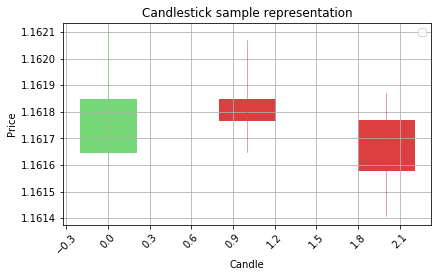

No handles with labels found to put in legend.


[0.554729]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


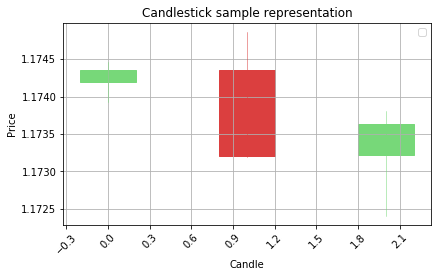

No handles with labels found to put in legend.


[0.5745725]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


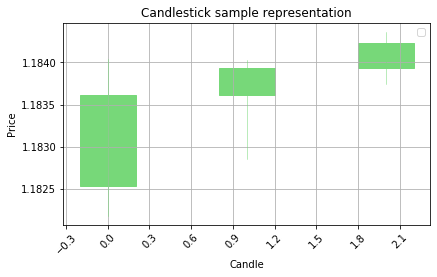

[0.55511844]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


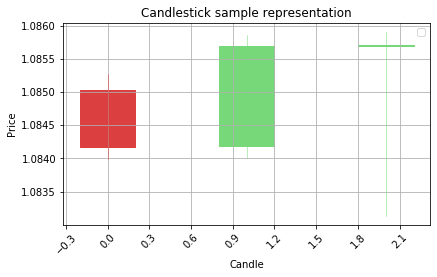

[0.565928]

No handles with labels found to put in legend.



Correct prediction is Bullish
Model prediction is Bearsih
LOST


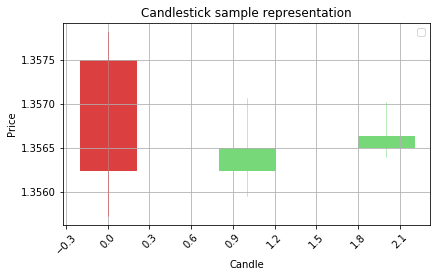

[0.55148464]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


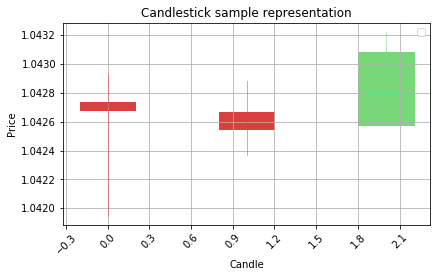

No handles with labels found to put in legend.


[0.5512878]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


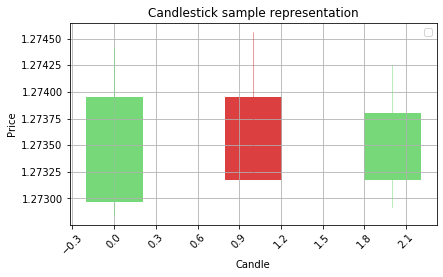

[0.5643109]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


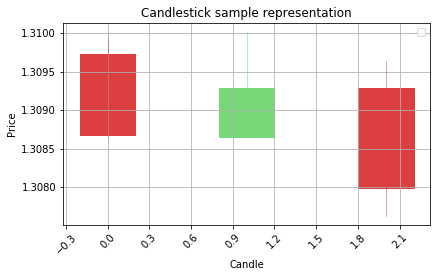

[0.5551295]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


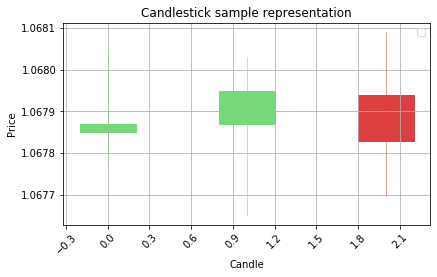

[0.5581121]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


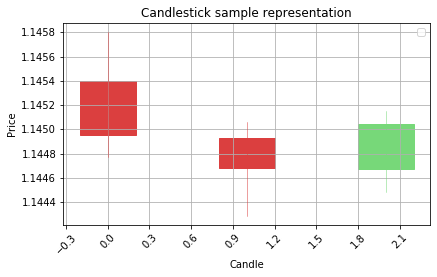

[0.5713915]

No handles with labels found to put in legend.



Correct prediction is Bullish
Model prediction is Bearsih
LOST


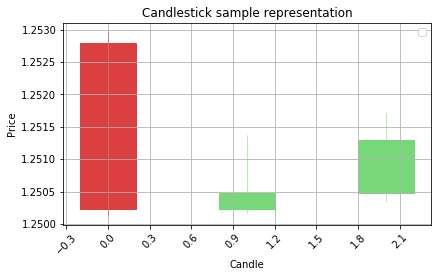

No handles with labels found to put in legend.


[0.5698511]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


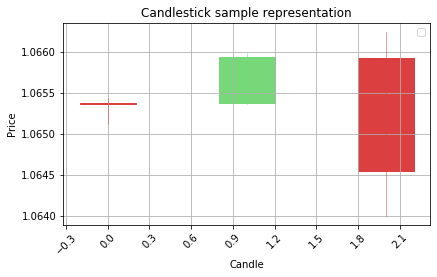

[0.5567238]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


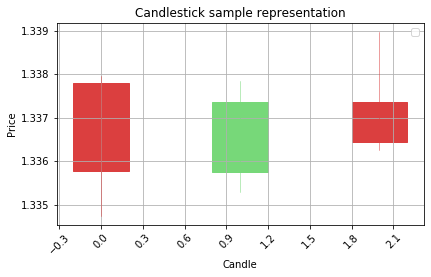

[0.55591476]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


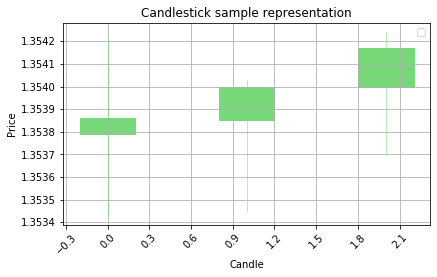

No handles with labels found to put in legend.


[0.5752257]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


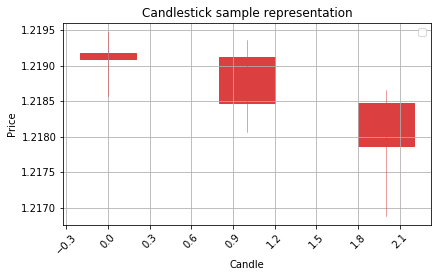

[0.56628215]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


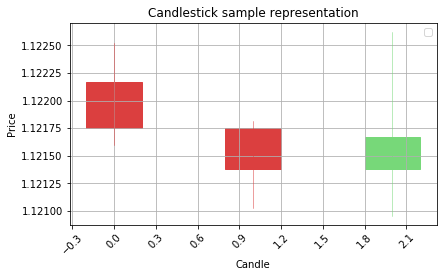

No handles with labels found to put in legend.


[0.5503957]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


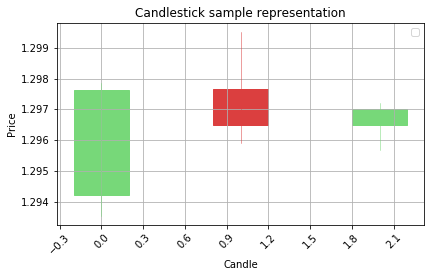

[0.55911255]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


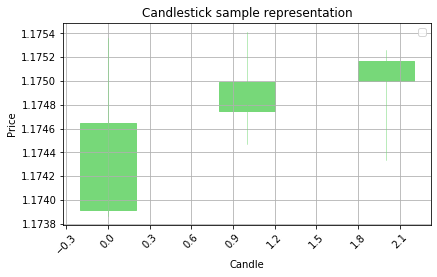

No handles with labels found to put in legend.


[0.5639568]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


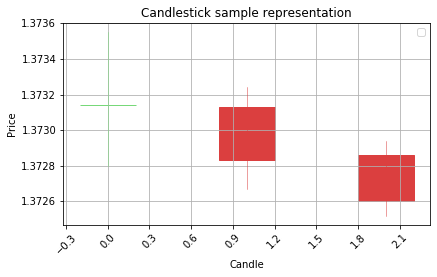

No handles with labels found to put in legend.


[0.5671215]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


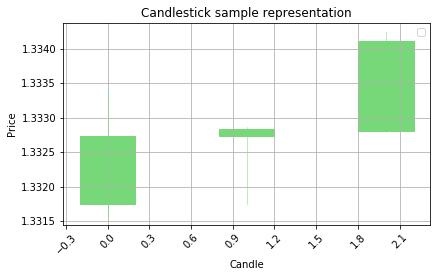

No handles with labels found to put in legend.


[0.5600849]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


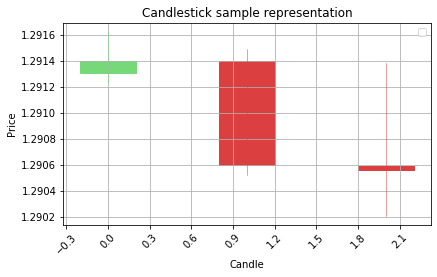

[0.55738753]
Correct prediction is Bullish
Model prediction is Bearsih

No handles with labels found to put in legend.



LOST


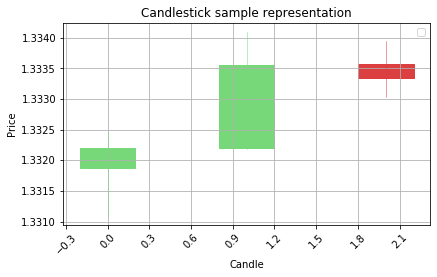

No handles with labels found to put in legend.


[0.55088973]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


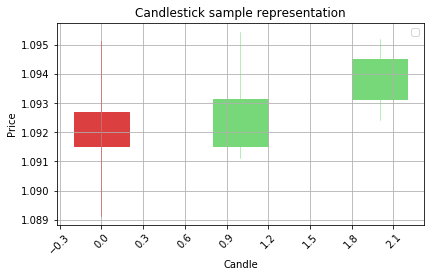

No handles with labels found to put in legend.


[0.561551]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


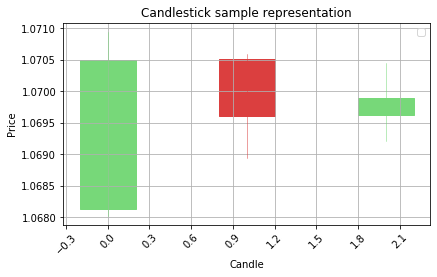

No handles with labels found to put in legend.


[0.55568075]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


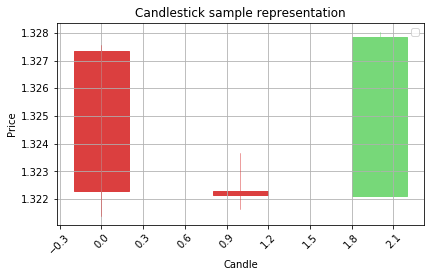

[0.55521494]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


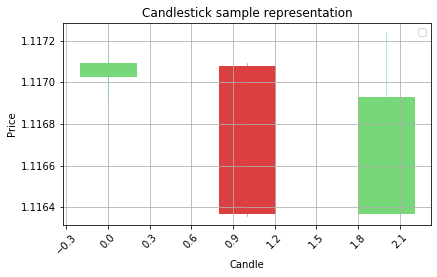

No handles with labels found to put in legend.


[0.555254]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


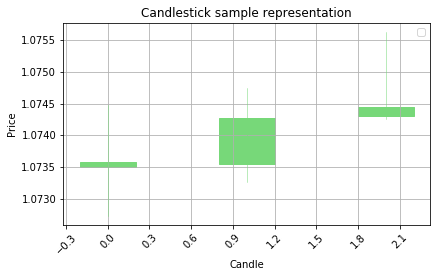

No handles with labels found to put in legend.


[0.5698317]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


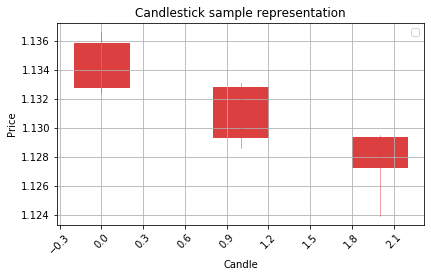

No handles with labels found to put in legend.


[0.55075586]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


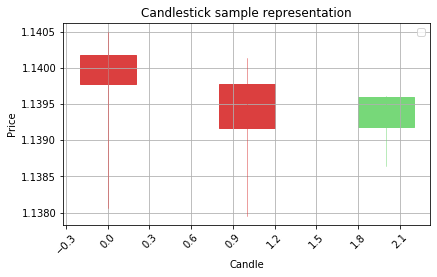

No handles with labels found to put in legend.


[0.56527823]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


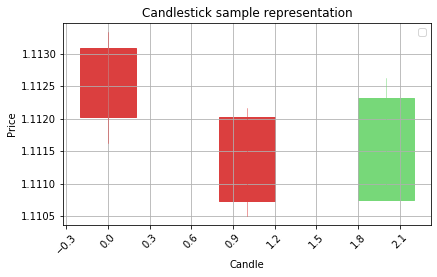

No handles with labels found to put in legend.


[0.5645123]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


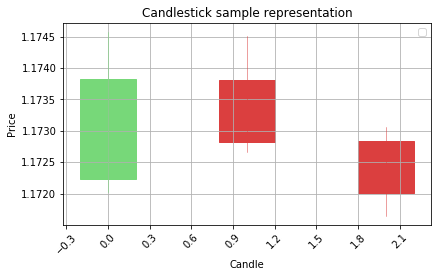

No handles with labels found to put in legend.


[0.55947506]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


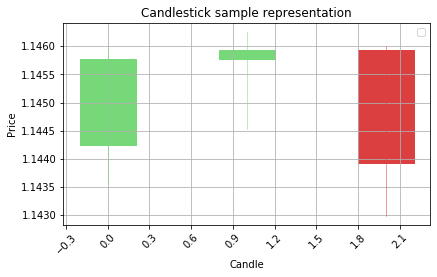

No handles with labels found to put in legend.


[0.5563185]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


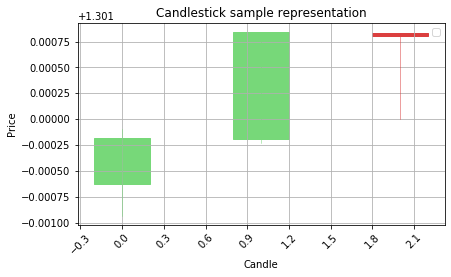

No handles with labels found to put in legend.


[0.55534387]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


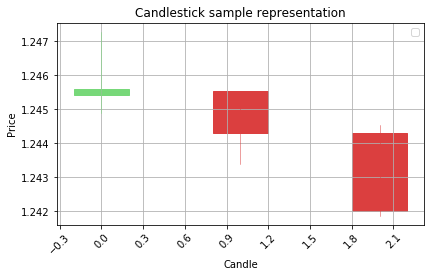

[0.5527606]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


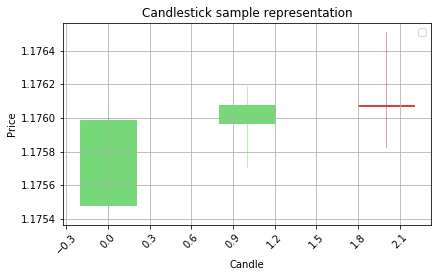

No handles with labels found to put in legend.


[0.5801045]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


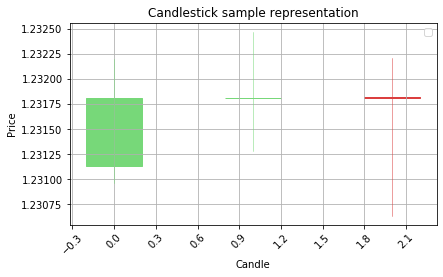

No handles with labels found to put in legend.


[0.55851907]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


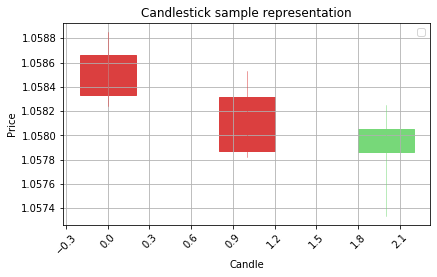

[0.561346]

No handles with labels found to put in legend.



Correct prediction is Bearsih
Model prediction is Bearsih
WON


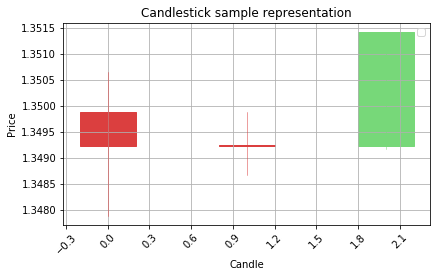

No handles with labels found to put in legend.


[0.5617944]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


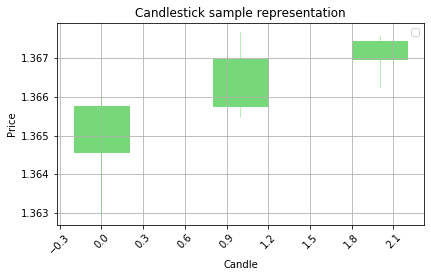

[0.5503367]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


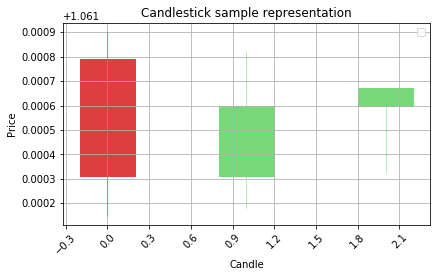

No handles with labels found to put in legend.


[0.5615022]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


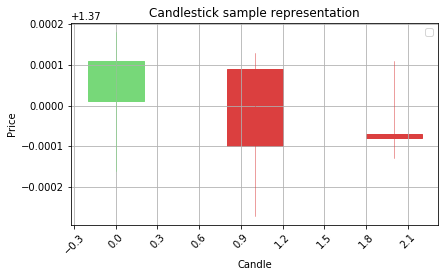

[0.5593158]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


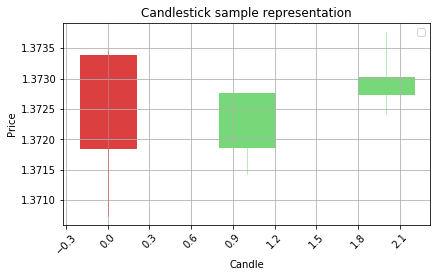

No handles with labels found to put in legend.


[0.5519731]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


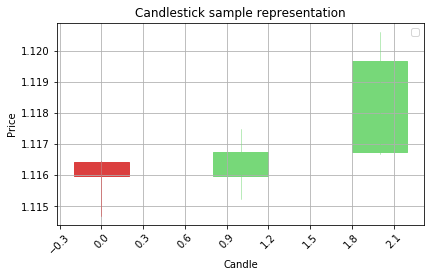

[0.56108993]
Correct prediction is Bearsih
Model prediction is Bearsih
WON


No handles with labels found to put in legend.


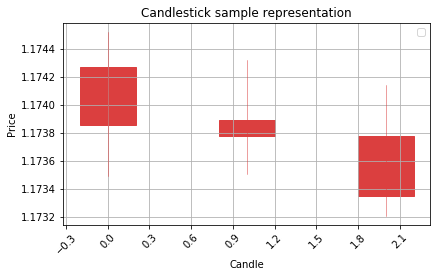

[0.56709117]
Correct prediction is Bullish
Model prediction is Bearsih
LOST


No handles with labels found to put in legend.


KeyboardInterrupt: 

In [37]:
counter = 0
for a in model.predict(X_test):
    if a > 0.55:
        print(str(a))
        #print(Y_test)
        if Y_test[counter] == 1:print('Correct prediction is Bullish')
        if Y_test[counter] == 0:print('Correct prediction is Bearsih')
        #print(np.argmax(a))
        if np.argmax(a) == 1:print('Model prediction is Bullish')
        if np.argmax(a) == 0:print('Model prediction is Bearsih')
        
        if np.argmax(a) == Y_test[counter]:print('WON')
        if np.argmax(a) != Y_test[counter]:print('LOST')
        
        graph_data_ohlc(X_test_raw[counter])
        
    counter=counter+1

### Get the feature importance to see based on what our deep learning model made his decisions

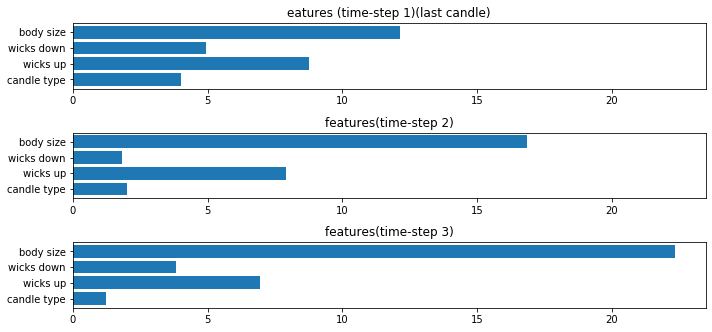

In [35]:
pred_x = model.predict(X_train)

random_ind = np.random.choice(X_train.shape[0], 1000, replace=False)

data = X_train[random_ind[0:500]]
e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output),data)
test1 = X_train[random_ind[500:1000]]
shap_val = e.shap_values(test1)
shap_val = np.array(shap_val)
shap_val = np.reshape(shap_val,(int(shap_val.shape[1]),int(shap_val.shape[2]),int(shap_val.shape[3])))
shap_abs = np.absolute(shap_val)
sum_0 = np.sum(shap_abs,axis=0)
f_names = ['candle type','wicks up', 'wicks down', 'body size']
x_pos = [i for i, _ in enumerate(f_names)]


plt.figure(figsize=(10,6))

plt1 = plt.subplot(4,1,1)
plt1.barh(x_pos,sum_0[2])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title('eatures (time-step 1)(last candle)')

plt2 = plt.subplot(4,1,2,sharex=plt1)
plt2.barh(x_pos,sum_0[1])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title('features(time-step 2)')

plt3 = plt.subplot(4,1,3,sharex=plt1)
plt3.barh(x_pos,sum_0[0])
plt3.set_yticks(x_pos)
plt3.set_yticklabels(f_names)
plt3.set_title('features(time-step 3)')

plt.tight_layout()
plt.show()

## Try convolutional 2D network

In [38]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


model = Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, X.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, Y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(X_val, Y_val)
                    )

ValueError: Input 0 is incompatible with layer conv1d_1: expected ndim=3, found ndim=4

In [40]:
X.shape[-1]

4